In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import string
import snscrape.modules.twitter as sntwitter
import joblib
from textblob import TextBlob
from nltk.stem import PorterStemmer
import nltk
nltk.download('averaged_perceptron_tagger')
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import (CountVectorizer,
                                             TfidfVectorizer)
from wordcloud import WordCloud
from collections import Counter
import re
import json

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\trans\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Raw Data

In [2]:
data_dir = './data/'
image_dir = './images/'

if not os.path.isdir(image_dir):
    os.mkdir(image_dir)

In [3]:
# Import stop words
with open(data_dir+'stopwords.txt', 'r') as f:
    stopwords = f.read().splitlines()

In [4]:
def subset_list(l, n):
    for i in range(0, len(l), n):
        yield l[i:i+n]                 

In [5]:
def scrape_tweets(list_of_tweets, method):
    if type(method) != str or method.lower() not in ('id', 'tweet'):
        raise ValueError('method must be "id" or "tweet"')
    
    #initalize storage lists
    vals_to_keep = ['tweetDate', 'tweet', 'tweetID', 'replyCount', 'retweetCount', 'likeCount', 
                    'quoteCount', 'language', 'source', 'links', 'media', 'coordinates', 'place', 'hashtags',
                    'userID', 'userDisplayName', 'userDescription', 'userVerified', 'userCreated', 
                    'userFollowerCount', 'userFollowingCount', 'userTweetCount', 'userFavoritesCount',
                    'userListedCount', 'userMediaCount', 'userLocation']
    num_attrs = len(vals_to_keep)
    tweet_info = {key:list() for key in vals_to_keep}
    
    if method.lower() == 'id':
        scraper = sntwitter.TwitterTweetScraper
    elif method.lower() == 'tweet':
        scraper = sntwitter.TwitterSearchScraper
        
    for raw_tweet in list_of_tweets:
        results = scraper(raw_tweet).get_items()
        
        tweet_found = True
        multiple_tweets_found = False
        
        try:
            tweet = next(results)
        except:
            tweet_found = False
        else:
            if type(tweet) == sntwitter.Tombstone:
                tweet_found = False
            if type(tweet) not in (sntwitter.Tombstone, sntwitter.Tweet):
                raise ValueError(f'unhandled type: {type(tweet)}')
                
            #check for multiple search results
            try:
                tweet2 = next(results)
            except:
                #only one found, so no problem
                pass
            else:
                if type(tweet2) in (sntwitter.Tombstone, sntwitter.Tweet):
                    #multiple returned tweets creates ambiguity as to which is correct
                    multiple_tweets_found = True
                    
        if tweet_found and not multiple_tweets_found:
            user = tweet.user
            current_info = [tweet.date, tweet.rawContent, tweet.id, tweet.replyCount, tweet.retweetCount, 
                            tweet.likeCount, tweet.quoteCount, tweet.lang, tweet.sourceLabel, tweet.links,
                            tweet.media, tweet.coordinates, tweet.place, tweet.hashtags, user.id, user.displayname,
                            user.rawDescription, user.verified, user.created, user.followersCount, user.friendsCount,
                            user.statusesCount, user.favouritesCount, user.listedCount, user.mediaCount, user.location]
            
            if tweet.place not in (None, ''):
                current_info[12] = tweet.place.fullName
                
            if tweet.links is None:
                current_info[9] = 0
            else:
                current_info[9] = len(tweet.links)
                
            if tweet.media is None:
                current_info[10] = 0
            else:
                current_info[10] = len(tweet.media)
                
            if tweet.coordinates in (None, ''):
                current_info[11] = pd.NA
            else:
                current_info[11] = [tweet.coordinates.latitude, tweet.coordinates.longitude]
                
            if tweet.hashtags in (None, ''):
                current_info[13] = pd.NA
            else:
                current_info[13] = ', '.join(tweet.hashtags)
                
            if user.location in (None, ''):
                current_info[25] = pd.NA
                
            if user.description in (None, ''):
                current_info[16] = pd.NA
                
        else:
            current_info = np.repeat([pd.NA], num_attrs)
            
        for key, value in zip(vals_to_keep, current_info):
            tweet_info[key].append(value)
    
    for key in vals_to_keep: 
        if len(tweet_info[key]) == 1:
            tweet_info[key] = tweet_info[key][0]
    
    return tweet_info

In [6]:
def parallel_scrape(list_of_tweets, method, savefile=None, num_cores=joblib.cpu_count(), chunk_size=10000):
    if type(list_of_tweets) not in (list, np.ndarray):
        raise AttributeError('list_of_tweets must be a list or numpy array')
        
    if chunk_size == -1:
        alljobs = [joblib.delayed(scrape_tweets)([tweet], method) for tweet in list_of_tweets]
        results = joblib.Parallel(n_jobs=num_cores, verbose=10)(alljobs)
        full_df = pd.DataFrame(results)
        full_df.to_csv(savefile, mode='w', index=False)
        
    else:
        full_df = pd.DataFrame()
        tweet_chunks = subset_list(list_of_tweets, chunk_size)
        count = 0
        for chunk in tweet_chunks:
            alljobs = [joblib.delayed(scrape_tweets)([tweet], method) for tweet in chunk]
            results = joblib.Parallel(n_jobs=num_cores, verbose=10)(alljobs)
            current_df = pd.DataFrame(results)
            full_df = pd.concat([full_df, current_df])
            
            if savefile is not None and count==0:
                current_df.to_csv(savefile, mode='w', index=False)
            elif savefile is not None and count>0:
                current_df.to_csv(savefile, mode='a', index=False)
            
    return full_df

In [7]:
def read_data(mode='fresh'):
    if type(mode) != str or mode.lower() not in ('fresh', 'file'):
        raise AttributeError("mode must be 'fresh' or 'file'")
                             
    type_changes = {'tweetDate':'datetime64[ns]',
                    'tweet':'string',
                    'tweetID':'uint64',
                    'replyCount':'uint32',
                    'retweetCount':'uint32',
                    'likeCount':'uint32',
                    'quoteCount':'uint32',
                    'language':'string',
                    'source':'string',
                    'links':'uint8',
                    'media':'uint8',
                    'coordinates':'string',
                    'place':'string',
                    'hashtags':'string',
                    'userID':'uint64',
                    'userDisplayName':'string',
                    'userDescription':'string',
                    'userVerified':'bool',
                    'userCreated':'datetime64[ns]',
                    'userFollowerCount':'uint32',
                    'userFollowingCount':'uint32',
                    'userTweetCount':'uint32',
                    'userFavoritesCount':'uint32',
                    'userListedCount':'uint32',
                    'userMediaCount':'uint32',
                    'userLocation':'string',
                    'label':'string'}
    
    if mode.lower() == 'file':
        all_tweets = pd.read_csv(data_dir+'scraped_tweets.csv')
        all_tweets = all_tweets.astype(type_changes)        
                             
    elif mode.lower() == 'fresh':                       
        # Import data from https://github.com/Gautamshahi/Misinformation_COVID-19/blob/master/Data/Dataset-I
        with open(data_dir+'misinformation_covid19.txt', 'r') as f:
            misinformation_covid19_tweets = f.read().splitlines()
            misinformation_covid19_tweets = misinformation_covid19_tweets[1:]
            misinformation_covid19_tweets = np.array([row.split('\t') for row in misinformation_covid19_tweets])
            misinformation_covid19_tweets = pd.DataFrame(data=misinformation_covid19_tweets, columns=['id', 'label'])
            misinformation_covid19_tweets = misinformation_covid19_tweets.astype({'id':'int64', 'label':'string'})

        # Import data from https://github.com/diptamath/covid_fake_news/tree/main/data
        covid_fake_news_tweets = pd.DataFrame()
        datasets = ['covid_fake_news1.csv', 'covid_fake_news2.csv', 'covid_fake_news3.csv']

        for dataset in datasets:
            covid_fake_news_tweets = pd.concat([covid_fake_news_tweets, pd.read_csv(data_dir+dataset)])

        covid_fake_news_tweets.loc[covid_fake_news_tweets['label']=='real', 'label']='TRUE'
        covid_fake_news_tweets.loc[covid_fake_news_tweets['label']=='fake', 'label']='FALSE'
        covid_fake_news_tweets = covid_fake_news_tweets.drop('id', axis=1)
        covid_fake_news_tweets = covid_fake_news_tweets.reset_index(drop=True)


        tweet_data = [misinformation_covid19_tweets.loc[:,'id'].to_numpy(),
                      covid_fake_news_tweets.loc[:,'tweet'].to_numpy()]

        tweet_labels = [misinformation_covid19_tweets.loc[:,'label'].to_numpy(),
                        covid_fake_news_tweets.loc[:,'label'].to_numpy()]

        scrape_types = ['id',
                        'tweet']

        names = ['misinformation_covid19',
                 'covid_fake_news']

        all_tweets = pd.DataFrame()
        for tweet_list, labels, method, name in zip(tweet_data, tweet_labels, scrape_types, names):
            current_df = parallel_scrape(list_of_tweets=tweet_list, 
                                         method=method, 
                                         savefile=data_dir+'_'+name+'temp.csv')
            current_df['label'] = labels
            current_df = current_df.dropna(subset=['tweet', 'tweetID'], how='all')
            current_df = current_df.reset_index(drop=True)
            current_df = current_df.astype(type_changes)
            all_tweets = pd.concat([all_tweets, current_df], ignore_index=True)
            os.remove(data_dir+'_'+name+'temp.csv') #delete temporary files

        #change types here as well since pd.concat sometimes removes type casting    
        all_tweets = all_tweets.astype(type_changes)
        all_tweets.to_csv(data_dir+'scraped_tweets.csv', index=False)
        
    return all_tweets

In [8]:
scraped_tweets = read_data(mode='file')

In [9]:
type_changes = {'tweetDate':'datetime64[ns]',
                'tweet':'string',
                'tweetID':'uint64',
                'replyCount':'uint32',
                'retweetCount':'uint32',
                'likeCount':'uint32',
                'quoteCount':'uint32',
                'language':'string',
                'source':'string',
                'links':'uint8',
                'media':'uint8',
                'coordinates':'string',
                'place':'string',
                'hashtags':'string',
                'userID':'uint64',
                'userDisplayName':'string',
                'userDescription':'string',
                'userVerified':'bool',
                'userCreated':'datetime64[ns]',
                'userFollowerCount':'uint32',
                'userFollowingCount':'uint32',
                'userTweetCount':'uint32',
                'userFavoritesCount':'uint32',
                'userListedCount':'uint32',
                'userMediaCount':'uint32',
                'userLocation':'string',
                'label':'string'}
tweets_df = pd.read_csv(data_dir+"scraped_tweets.csv")
tweets_df = tweets_df.astype(type_changes)
tweets_df.head()

tweetDate                                              tweet  \
0 2020-07-24 12:44:01  @senadormotoa @MinSaludCol Equivocado de princ...   
1 2020-05-26 00:56:04  Ian Haydon, who is participating in a vaccine ...   
2 2020-06-10 09:30:07  দাবী: ছ'চিয়েল মিডিয়াত প্ৰচাৰ হৈ থকা এখন ফটো ...   
3 2020-04-21 02:16:11  Gachibowli Sports Tower turns Covid hospital

...   
4 2020-04-24 19:04:33  Protesters at state Capitol are chanting "Wher...   

               tweetID  replyCount  retweetCount  likeCount  quoteCount  \
0  1286643297402920960           7             6         16           0   
1  1265084253357907969          22            61        191          21   
2  1270649437111672838           0             0          1           0   
3  1252420840957730816          11            46        409           4   
4  1253761766787555335          21           192        564          98   

  language source  links  ...  userVerified         userCreated  \
0       es   <NA>      0  ...         False 2010-05-11 21:19:44   
1       en   <NA>      0  ...          True 2010-12-17 23:37:19   
2       bn   <NA>      0  ...          True 2013-02-25 11:34:24   
3       en   <NA>      1  ...          True 2014-03-06 10:51:29   
4       en   <NA>      0  ...          True 2009-04-03 19:40:20   

  userFollowerCount userFollowingCount  userTweetCount userFavoritesCount  \
0            201480                665           32542               2183   
1           1644782                155           69269                393   
2             21893                158           52062                395   
3            820775                124           26381              12780   
4             29419               4949           38864               1041   

  userListedCount  userMediaCount          userLocation            label  
0             395            3205        Cali, Colombia            FALSE  
1            6990           19309          New York, NY  partially false  
2              89           27017       Guwahati, India            FALSE  
3             254           13021  Hyderabad, Telangana            FALSE  
4             897            3130    Madison, Wisconsin            FALSE  

[5 rows x 27 columns]

In [10]:
tweets_df.columns

Index(['tweetDate', 'tweet', 'tweetID', 'replyCount', 'retweetCount',
       'likeCount', 'quoteCount', 'language', 'source', 'links', 'media',
       'coordinates', 'place', 'hashtags', 'userID', 'userDisplayName',
       'userDescription', 'userVerified', 'userCreated', 'userFollowerCount',
       'userFollowingCount', 'userTweetCount', 'userFavoritesCount',
       'userListedCount', 'userMediaCount', 'userLocation', 'label'],
      dtype='object')

In [11]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6863 entries, 0 to 6862
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweetDate           6863 non-null   datetime64[ns]
 1   tweet               6863 non-null   string        
 2   tweetID             6863 non-null   uint64        
 3   replyCount          6863 non-null   uint32        
 4   retweetCount        6863 non-null   uint32        
 5   likeCount           6863 non-null   uint32        
 6   quoteCount          6863 non-null   uint32        
 7   language            6863 non-null   string        
 8   source              5274 non-null   string        
 9   links               6863 non-null   uint8         
 10  media               6863 non-null   uint8         
 11  coordinates         97 non-null     string        
 12  place               97 non-null     string        
 13  hashtags            3191 non-null   string      

## Null Values

In [12]:
tweets_df.isna().any()

tweetDate             False
tweet                 False
tweetID               False
replyCount            False
retweetCount          False
likeCount             False
quoteCount            False
language              False
source                 True
links                 False
media                 False
coordinates            True
place                  True
hashtags               True
userID                False
userDisplayName       False
userDescription        True
userVerified          False
userCreated           False
userFollowerCount     False
userFollowingCount    False
userTweetCount        False
userFavoritesCount    False
userListedCount       False
userMediaCount        False
userLocation           True
label                 False
dtype: bool

In [13]:
tweets_df = tweets_df.dropna(subset=['tweet', 'tweetID'])

In [14]:
tweets_df.isna().any()

tweetDate             False
tweet                 False
tweetID               False
replyCount            False
retweetCount          False
likeCount             False
quoteCount            False
language              False
source                 True
links                 False
media                 False
coordinates            True
place                  True
hashtags               True
userID                False
userDisplayName       False
userDescription        True
userVerified          False
userCreated           False
userFollowerCount     False
userFollowingCount    False
userTweetCount        False
userFavoritesCount    False
userListedCount       False
userMediaCount        False
userLocation           True
label                 False
dtype: bool

In [15]:
english_tweets_df = tweets_df.loc[tweets_df['language']=='en', tweets_df.columns]
english_tweets_df = english_tweets_df.reset_index(drop=True)
modified_tweets_df = english_tweets_df.copy()

modified_tweets_df['tweet'] = [tweet.replace('&amp;', '&') for tweet in modified_tweets_df['tweet']]

In [16]:
modified_tweets_df['has_links'] = modified_tweets_df['links'].apply(lambda x: x>0)

In [17]:
modified_tweets_df

tweetDate                                              tweet  \
0    2020-05-26 00:56:04  Ian Haydon, who is participating in a vaccine ...   
1    2020-04-21 02:16:11  Gachibowli Sports Tower turns Covid hospital\n...   
2    2020-04-24 19:04:33  Protesters at state Capitol are chanting "Wher...   
3    2020-03-11 16:26:53  🚨 BREAKING 🚨\n\n"We have therefore made the as...   
4    2020-06-08 19:53:19  1/2\n\n@WHO recently published a summary of tr...   
...                  ...                                                ...   
6076 2020-02-27 14:08:01  NEWS! Coronavirus crisis in Italy leads Donald...   
6077 2020-05-10 19:31:01  Visits to doctor’s offices and emergency rooms...   
6078 2020-04-02 16:42:41  A major concern is that specificity is not tes...   
6079 2020-09-16 05:00:22  #CoronaVirusUpdates: \n\nState-wise details of...   
6080 2020-06-10 09:05:00  More than half of pregnant women recently admi...   

                  tweetID  replyCount  retweetCount  likeCount  quoteCount  \
0     1265084253357907969          22            61        191          21   
1     1252420840957730816          11            46        409           4   
2     1253761766787555335          21           192        564          98   
3     1237777021742338049        1969         49994      51375       13227   
4     1270081492908216320         100           283        604         134   
...                   ...         ...           ...        ...         ...   
6076  1233031034092097536           0            11         16           0   
6077  1259566633087107075          40           127        299          11   
6078  1245753530205589504           2             3         18           0   
6079  1306095560386961409           2            56        109           2   
6080  1270643113581830149           0             3          2           3   

     language               source  links  ...         userCreated  \
0          en                 <NA>      0  ... 2010-12-17 23:37:19   
1          en                 <NA>      1  ... 2014-03-06 10:51:29   
2          en                 <NA>      0  ... 2009-04-03 19:40:20   
3          en                 <NA>      0  ... 2008-04-23 19:56:27   
4          en                 <NA>      1  ... 2013-11-12 22:07:25   
...       ...                  ...    ...  ...                 ...   
6076       en            NewsThump      1  ... 2009-02-18 10:35:53   
6077       en        Sprout Social      1  ... 2010-05-21 19:40:40   
6078       en      Twitter Web App      0  ... 2020-03-08 07:40:57   
6079       en  Twitter for Android      0  ... 2020-03-31 07:41:35   
6080       en   Sprinklr Publisher      1  ... 2008-10-21 19:26:01   

     userFollowerCount userFollowingCount userTweetCount  userFavoritesCount  \
0              1644782                155          69269                 393   
1               820775                124          26381               12780   
2                29419               4949          38864                1041   
3             12184674               1773          73738               12449   
4               116394                592           6403               10295   
...                ...                ...            ...                 ...   
6076             65590               3375          32377                1086   
6077           5510917                254          35072                 510   
6078            409286                 13           2677                  86   
6079            220413                 76          37010                2765   
6080            252855              37613          63541                2730   

     userListedCount userMediaCount          userLocation            label  \
0               6990          19309          New York, NY  partially false   
1                254          13021  Hyderabad, Telangana            FALSE   
2                897           3130    Madison, Wisconsin            FALSE   
3              

## Preprocessing

In [18]:
#manually remove certain unimportant words from the tweets
new_tweets = list()
new_tweets_stemmed = list()
for tweet in modified_tweets_df['tweet']:
    terms = tweet.split()
    new_terms = list()
    new_terms_stemmed = list()
    for term in terms:
        term = term.lower()
        #if term[0] in ('@', '#'): #keep or remove hashtags from tweets?
        if term[0] in ('@'):
            continue
        #if hashtags are being kept, don't remove them so they can be recognized as hashtags
        term = term.translate(str.maketrans('', '', string.punctuation.replace('#', '')))
        if len(term) <= 0:
            continue
        if term=='rt':
            continue
        if term.find('http') >= 0:
            continue
        if term in string.punctuation:
            continue
        try:
            #remove terms that are just numbers
            float(term)
        except:
            pass
        else:
            continue
        if term in stopwords or term in ['coronavirus', 'covid', 'covid-19', 'covid19']:
            continue
        
        new_terms.append(term)
        new_terms_stemmed.append(PorterStemmer().stem(term))
    new_tweets.append(' '.join(new_terms))
    new_tweets_stemmed.append(' '.join(new_terms_stemmed))
modified_tweets_df['tweet'] = new_tweets
modified_tweets_df['stemmed_tweet'] = new_tweets_stemmed

In [19]:
# removing emoticons
rem_emoticon = re.compile(r'(?!#)((\W+\s)|\W)|\.') #equivalent to above but keeps tweet hashtags
modified_tweets_df['tweet'] = modified_tweets_df['tweet'].apply(lambda x: rem_emoticon.sub(' ', x))
modified_tweets_df['stemmed_tweet'] = modified_tweets_df['stemmed_tweet'].apply(lambda x: rem_emoticon.sub(' ', x))

In [20]:
modified_tweets_df['tweet'] = modified_tweets_df['tweet'].apply(lambda x: x.strip())
modified_tweets_df['stemmed_tweet'] = modified_tweets_df['stemmed_tweet'].apply(lambda x: x.strip())

In [21]:
modified_tweets_df

tweetDate                                              tweet  \
0    2020-05-26 00:56:04  ian haydon participating vaccine trial feels  ...   
1    2020-04-21 02:16:11  gachibowli sports tower turns hospital 14story...   
2    2020-04-24 19:04:33  protesters state capitol chanting flag pointin...   
3    2020-03-11 16:26:53  breaking assessment #covid19 characterized pan...   
4    2020-06-08 19:53:19  published summary transmission #covid19 incl s...   
...                  ...                                                ...   
6076 2020-02-27 14:08:01  news crisis italy leads donald trump close piz...   
6077 2020-05-10 19:31:01  visits doctor s offices emergency rooms illnes...   
6078 2020-04-02 16:42:41  major concern specificity tested samples antib...   
6079 2020-09-16 05:00:22  #coronavirusupdates statewise details total co...   
6080 2020-06-10 09:05:00  half pregnant women admitted uk hospital infec...   

                  tweetID  replyCount  retweetCount  likeCount  quoteCount  \
0     1265084253357907969          22            61        191          21   
1     1252420840957730816          11            46        409           4   
2     1253761766787555335          21           192        564          98   
3     1237777021742338049        1969         49994      51375       13227   
4     1270081492908216320         100           283        604         134   
...                   ...         ...           ...        ...         ...   
6076  1233031034092097536           0            11         16           0   
6077  1259566633087107075          40           127        299          11   
6078  1245753530205589504           2             3         18           0   
6079  1306095560386961409           2            56        109           2   
6080  1270643113581830149           0             3          2           3   

     language               source  links  ...  userFollowerCount  \
0          en                 <NA>      0  ...            1644782   
1          en                 <NA>      1  ...             820775   
2          en                 <NA>      0  ...              29419   
3          en                 <NA>      0  ...           12184674   
4          en                 <NA>      1  ...             116394   
...       ...                  ...    ...  ...                ...   
6076       en            NewsThump      1  ...              65590   
6077       en        Sprout Social      1  ...            5510917   
6078       en      Twitter Web App      0  ...             409286   
6079       en  Twitter for Android      0  ...             220413   
6080       en   Sprinklr Publisher      1  ...             252855   

     userFollowingCount userTweetCount userFavoritesCount  userListedCount  \
0                   155          69269                393             6990   
1                   124          26381              12780              254   
2                  4949          38864               1041              897   
3                  1773          73738              12449            35514   
4                   592           6403              10295             1876   
...                 ...            ...                ...              ...   
6076               3375          32377               1086             1102   
6077                254          35072                510            19799   
6078                 13           2677                 86             5854   
6079                 76          37010               2765              457   
6080              37613          63541               2730             3258   

     userMediaCount          userLocation            label has_links  \
0             19309          New York, NY  partially false     False   
1             13021  Hyderabad, Telangana            FALSE      True   
2              3130    Madison, Wisconsin            FALSE     False   
3             21443   Geneva, Switzerland         unproven     False   
4  

# Exploratory Data Analysis

## Label Distribution

In [22]:
modified_tweets_df.label.unique()

<StringArray>
['partially false', 'FALSE', 'unproven', 'others', 'TRUE']
Length: 5, dtype: string

In [23]:
modified_tweets_df.label.value_counts()

TRUE               3496
FALSE              2388
partially false     162
others               26
unproven              9
Name: label, dtype: Int64

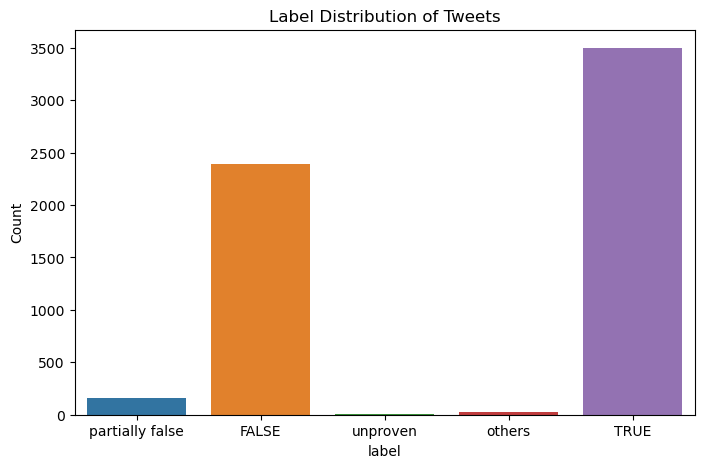

In [24]:
plt.figure(figsize=(8, 5))
sns.countplot(x=modified_tweets_df.label)
plt.title("Label Distribution of Tweets")
plt.ylabel("Count")
plt.savefig(image_dir+'label_distirbution.png', bbox_inches='tight')
plt.show()

## Word Counts

In [25]:
modified_tweets_df["word_count"] = modified_tweets_df['tweet'].apply(lambda x: len(x.split()))

In [26]:
modified_tweets_df["word_count"]

0       18
1       16
2       15
3        6
4       14
        ..
6076     8
6077    20
6078    10
6079    21
6080    14
Name: word_count, Length: 6081, dtype: int64

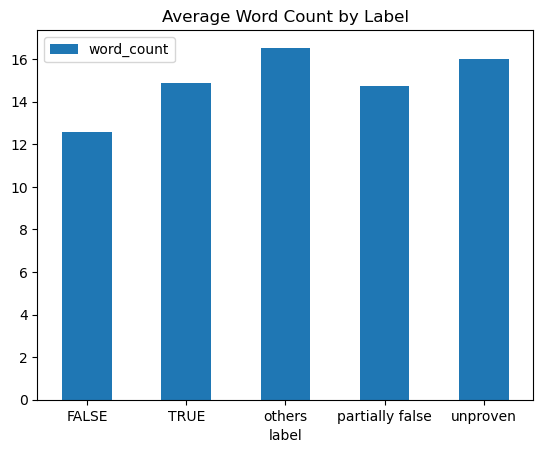

In [27]:
ax = modified_tweets_df[['word_count', 'label']].groupby(by = "label").mean().plot(kind="bar")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title("Average Word Count by Label")
plt.savefig(image_dir+'label_word_count.png', bbox_inches='tight')
plt.show()

## Link

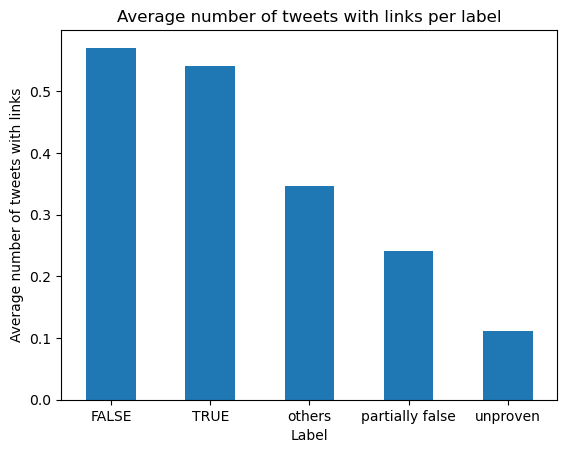

In [28]:
link_counts = modified_tweets_df.groupby('label')['has_links'].mean()
link_counts.plot(kind='bar')
plt.xlabel('Label')
plt.xticks(rotation=0)
plt.ylabel('Average number of tweets with links')
plt.title('Average number of tweets with links per label')
plt.savefig(image_dir+'links_per_label.png', bbox_inches='tight')
plt.show()

## Polarity

In [29]:
modified_tweets_df['polarity']=modified_tweets_df['tweet'].apply(lambda x:TextBlob(x).sentiment.polarity)

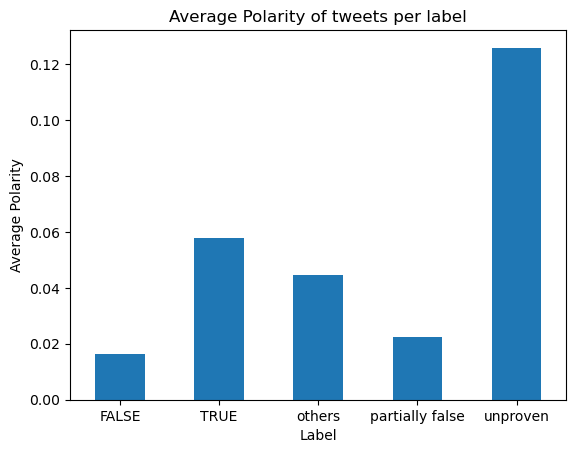

In [30]:
pol = modified_tweets_df.groupby('label')['polarity'].mean()
pol.plot(kind='bar')
plt.xlabel('Label')
plt.xticks(rotation=0)
plt.ylabel('Average Polarity')
plt.title('Average Polarity of tweets per label')
plt.savefig(image_dir+'polarity_per_label.png', bbox_inches='tight')
plt.show()

In [31]:
tweet_time = modified_tweets_df['tweetDate']
account_time = modified_tweets_df['userCreated']
modified_tweets_df['accountAgeAtPosting_days'] = (tweet_time-account_time).dt.days
modified_tweets_df.head()

tweetDate                                              tweet  \
0 2020-05-26 00:56:04  ian haydon participating vaccine trial feels  ...   
1 2020-04-21 02:16:11  gachibowli sports tower turns hospital 14story...   
2 2020-04-24 19:04:33  protesters state capitol chanting flag pointin...   
3 2020-03-11 16:26:53  breaking assessment #covid19 characterized pan...   
4 2020-06-08 19:53:19  published summary transmission #covid19 incl s...   

               tweetID  replyCount  retweetCount  likeCount  quoteCount  \
0  1265084253357907969          22            61        191          21   
1  1252420840957730816          11            46        409           4   
2  1253761766787555335          21           192        564          98   
3  1237777021742338049        1969         49994      51375       13227   
4  1270081492908216320         100           283        604         134   

  language source  links  ...  userFavoritesCount userListedCount  \
0       en   <NA>      0  ...                 393            6990   
1       en   <NA>      1  ...               12780             254   
2       en   <NA>      0  ...                1041             897   
3       en   <NA>      0  ...               12449           35514   
4       en   <NA>      1  ...               10295            1876   

  userMediaCount          userLocation            label has_links  \
0          19309          New York, NY  partially false     False   
1          13021  Hyderabad, Telangana            FALSE      True   
2           3130    Madison, Wisconsin            FALSE     False   
3          21443   Geneva, Switzerland         unproven     False   
4            323   Geneva, Switzerland            FALSE      True   

                                       stemmed_tweet  word_count polarity  \
0  ian haydon particip vaccin trial feel  total n...          18    0.075   
1  gachibowli sport tower turn hospit 14stori spo...          16   -0.050   
2  protest state capitol chant flag point capitol...          15    0.000   
3  break assess #covid19 character pandemicdrtedr...           6    0.000   
4  publish summari transmiss #covid19 incl sympto...          14    0.000   

   accountAgeAtPosting_days  
0                      3447  
1                      2237  
2                      4038  
3                      4339  
4                      2399  

[5 rows x 32 columns]

In [32]:
for col in modified_tweets_df.columns:
    if modified_tweets_df[col].dtype == 'string':
        modified_tweets_df = modified_tweets_df.fillna('Unknown')

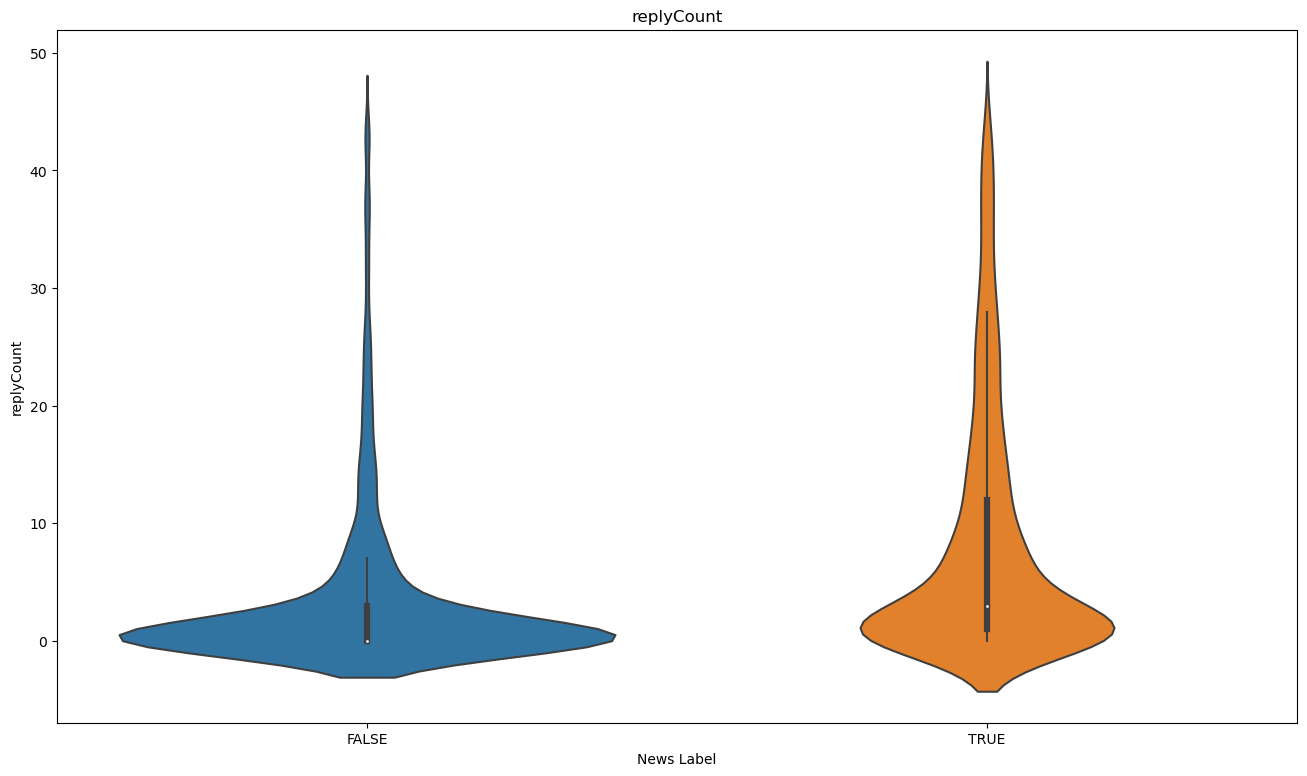

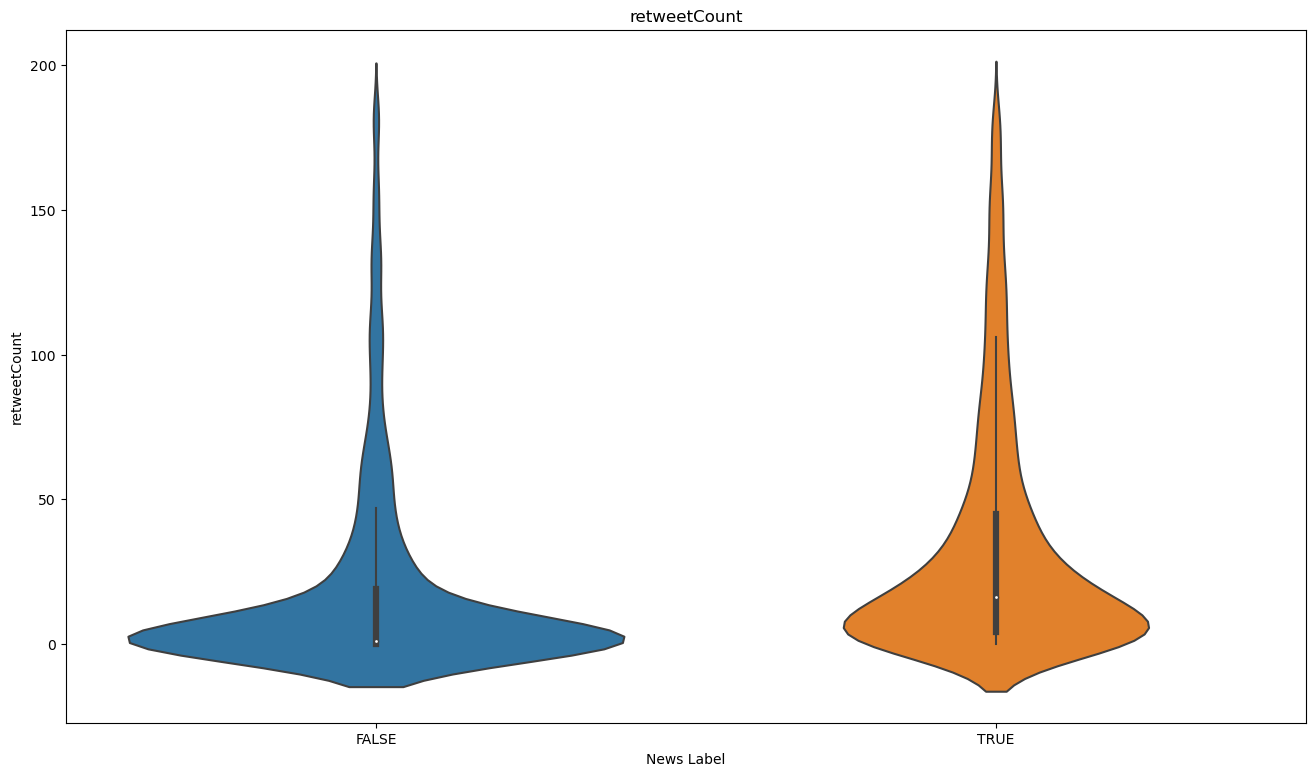

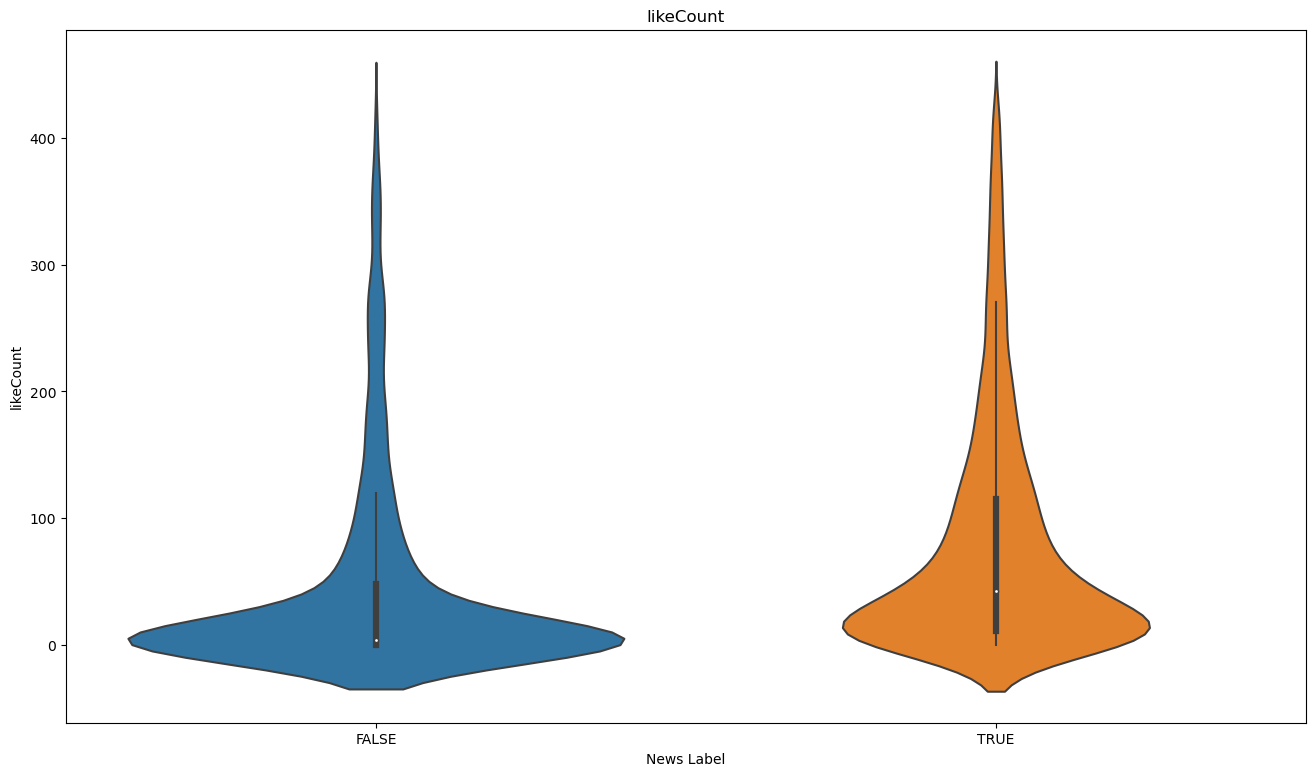

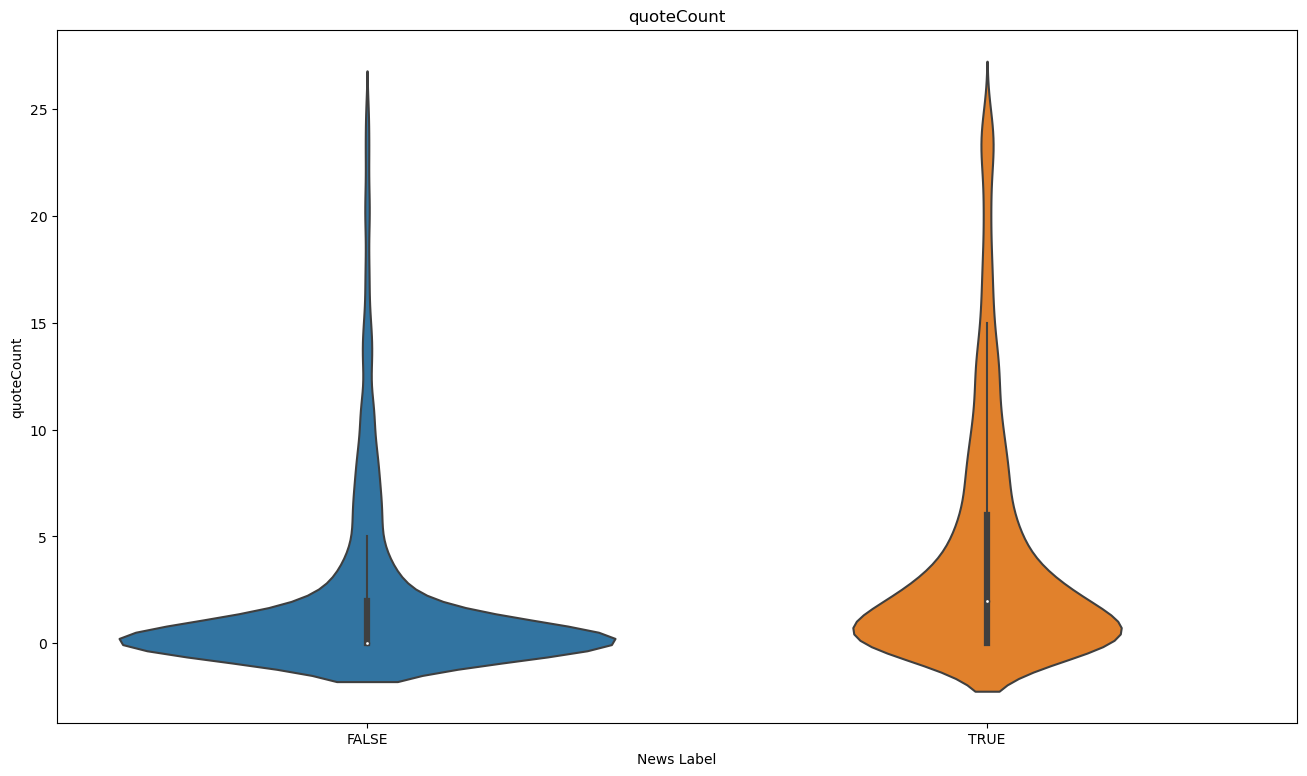

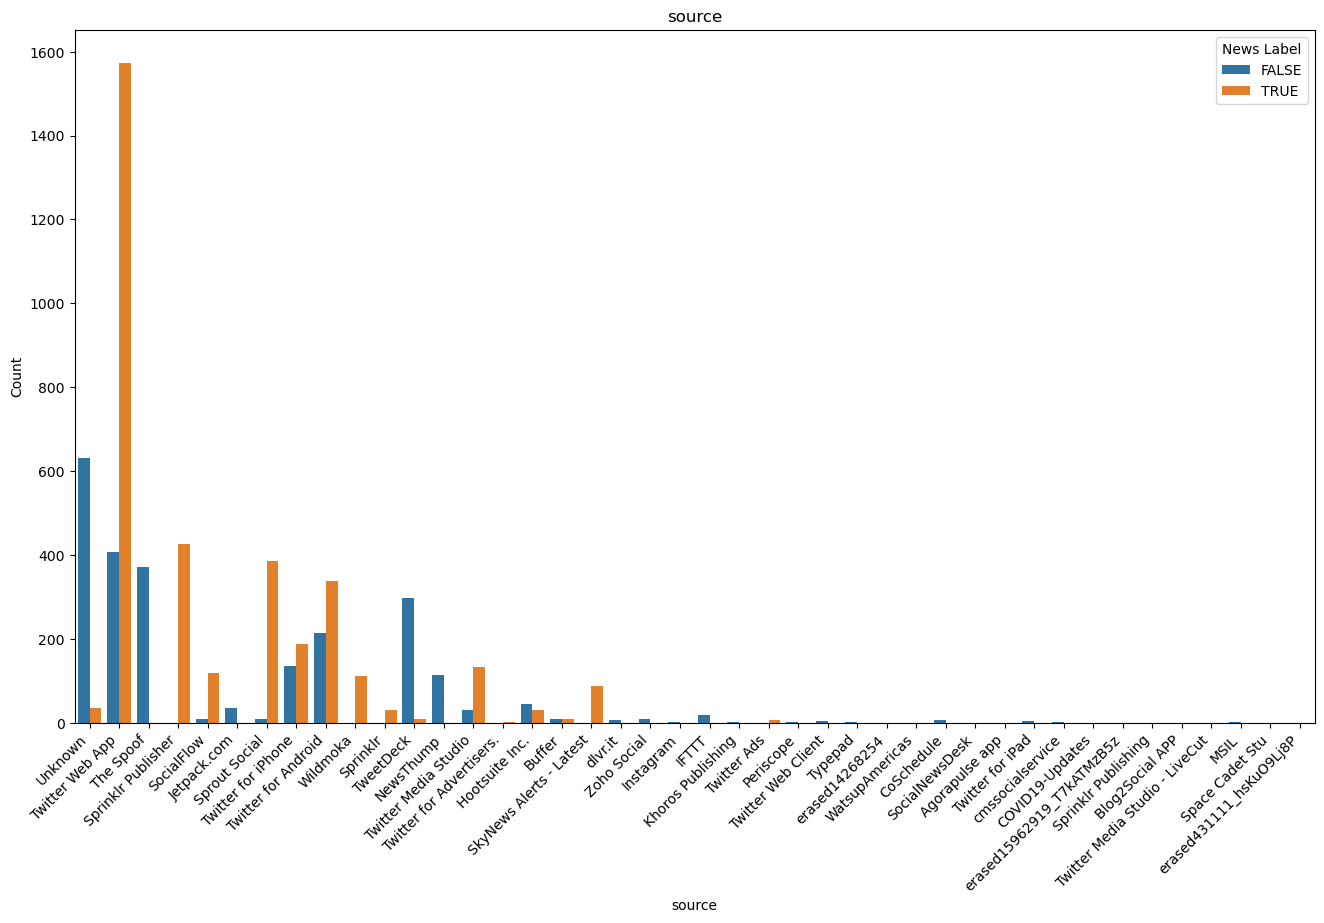

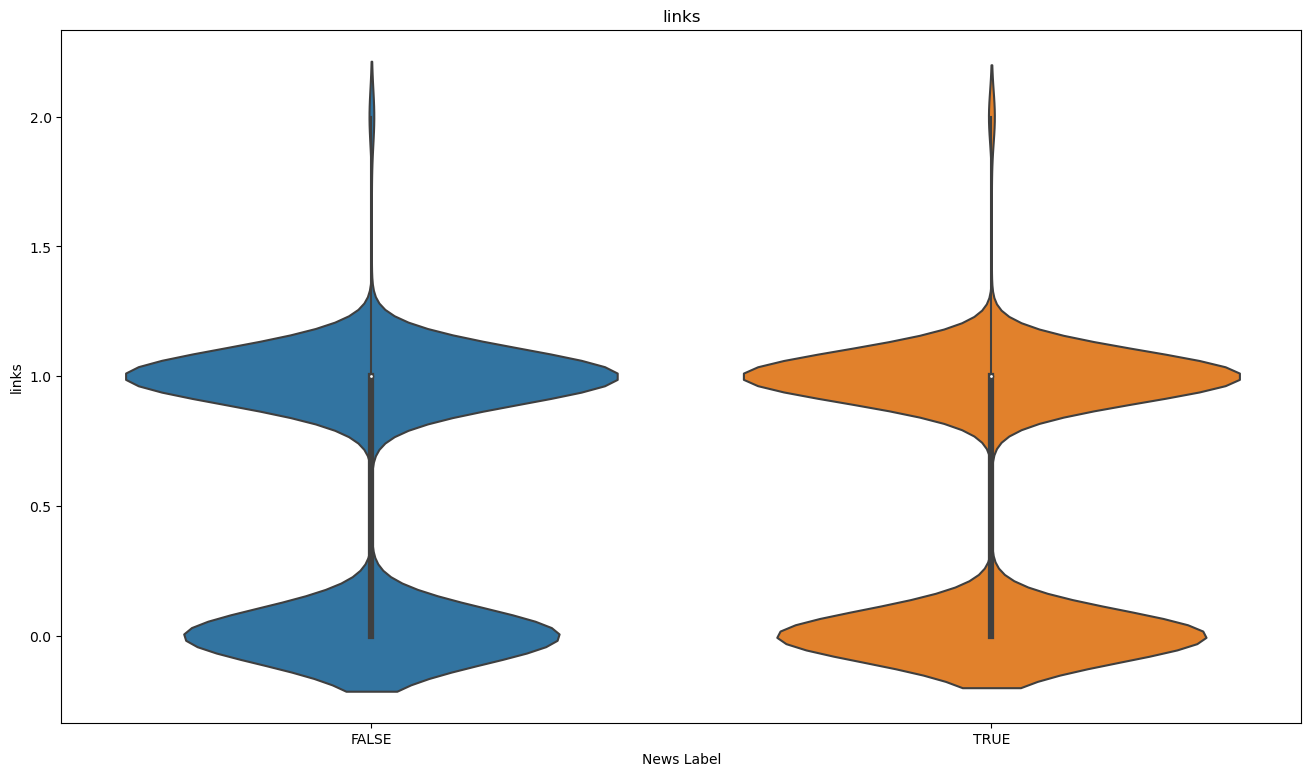

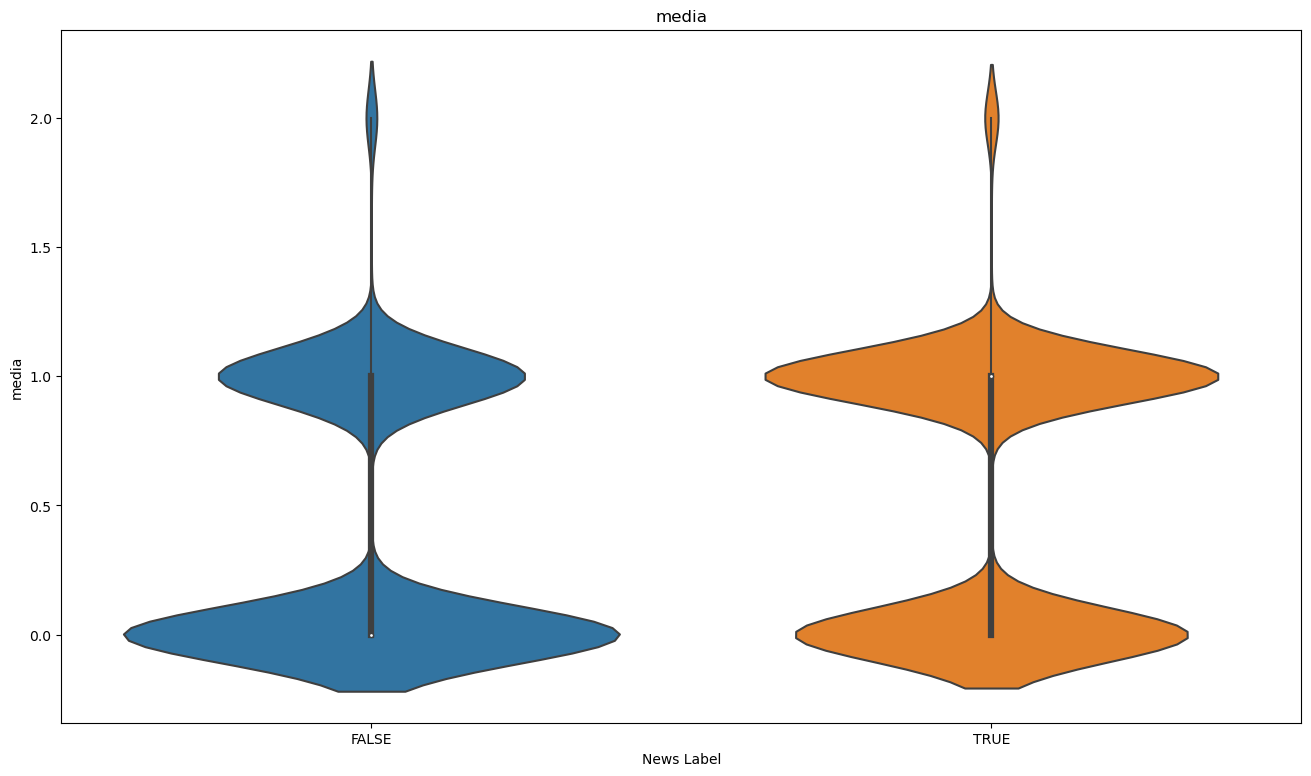

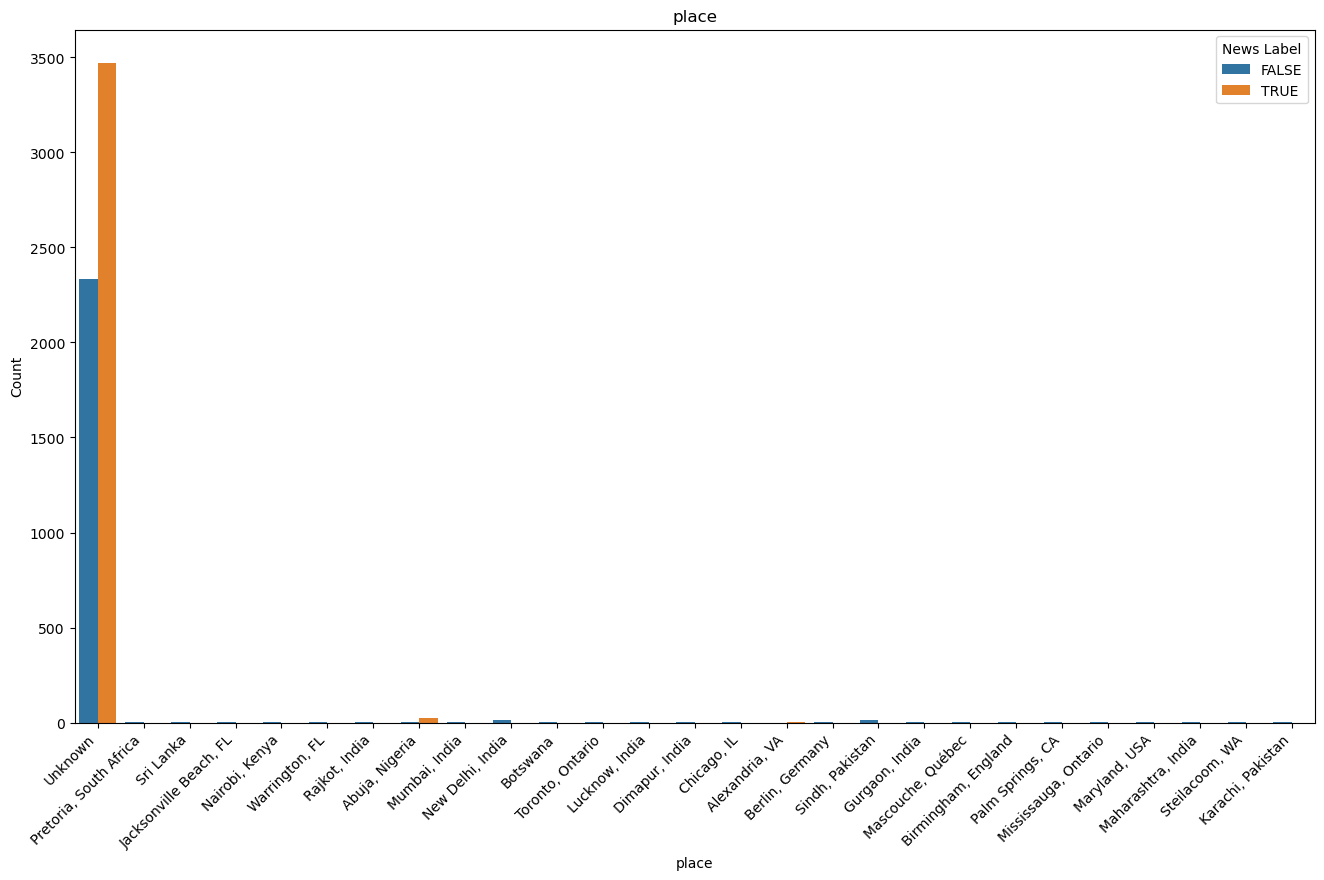

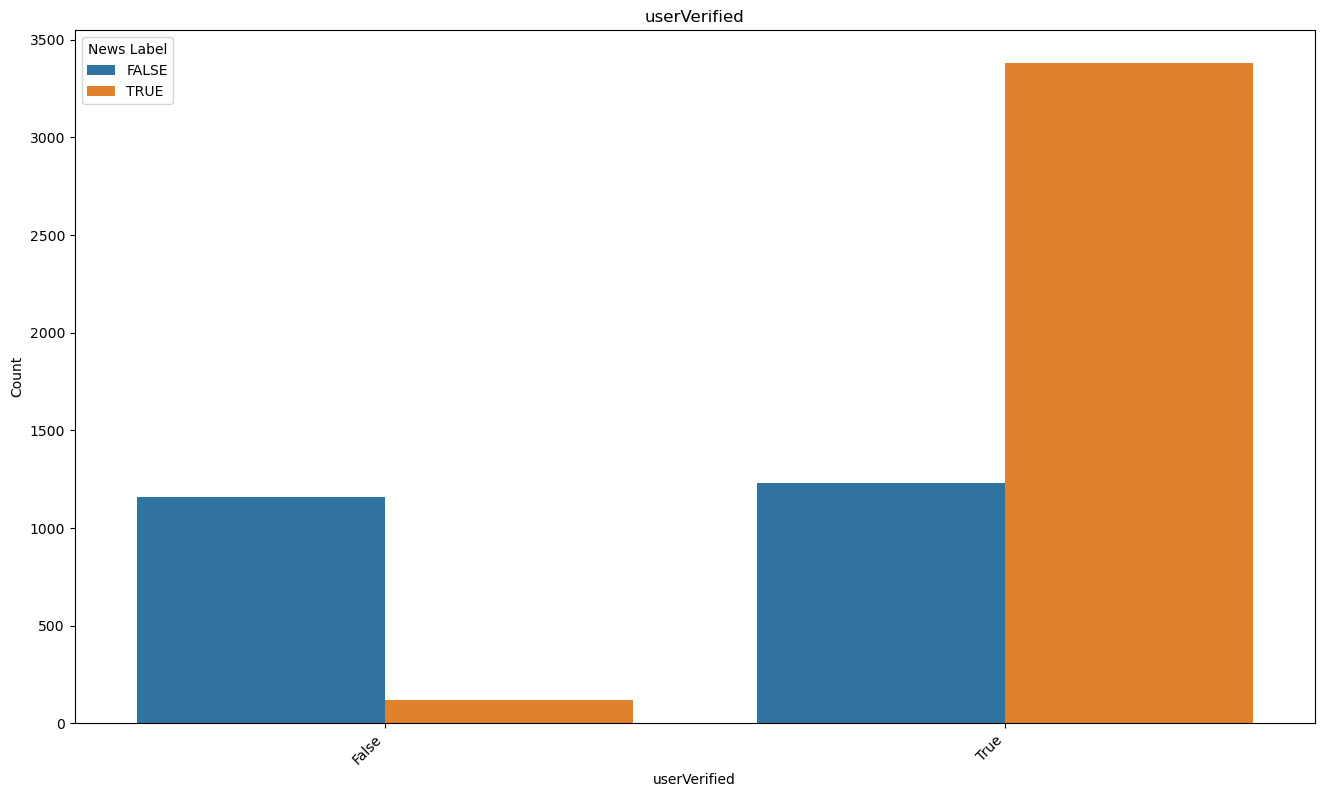

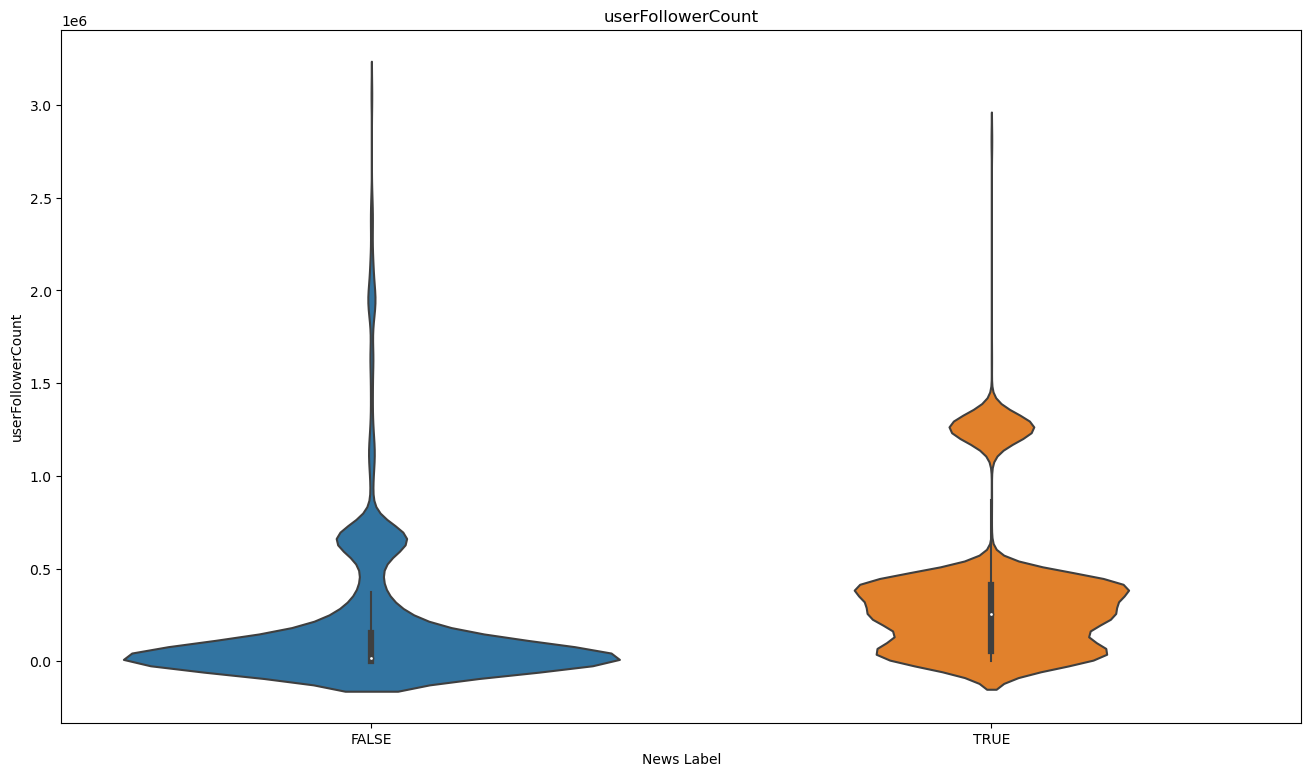

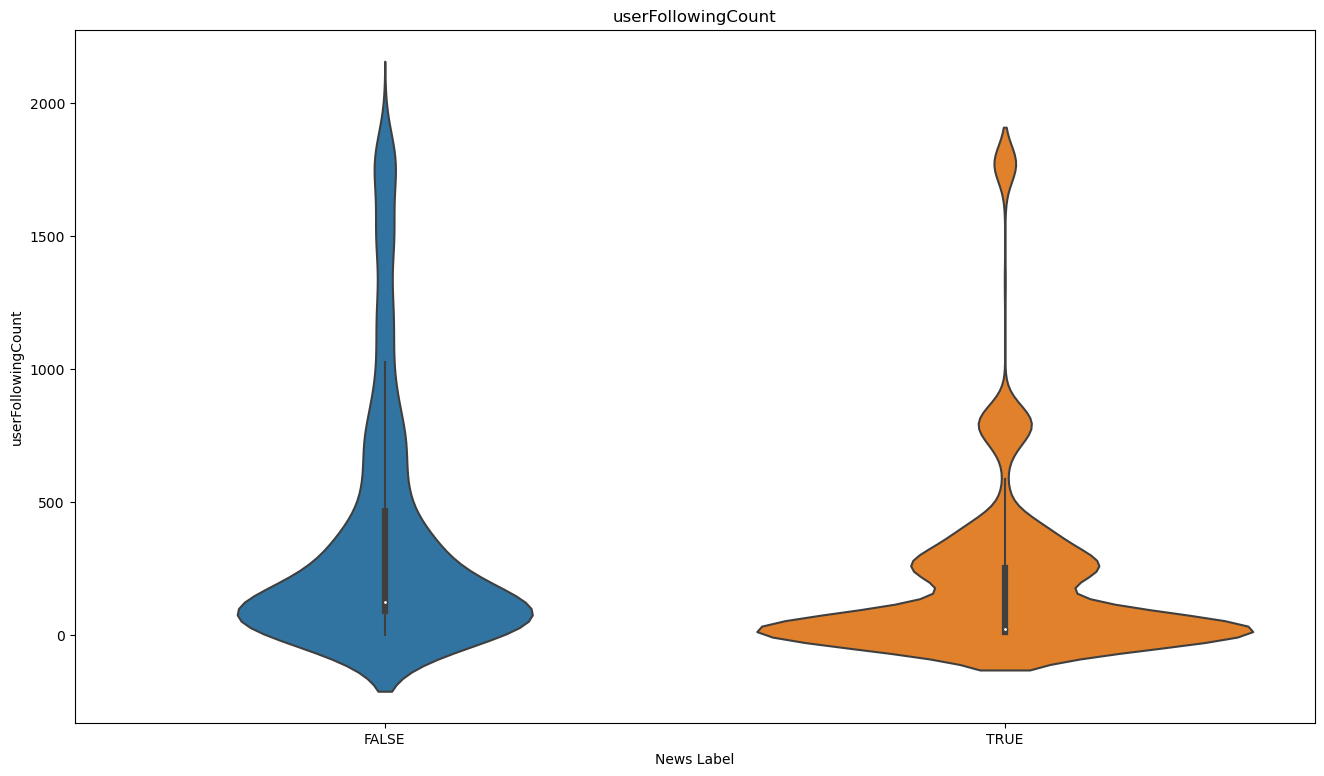

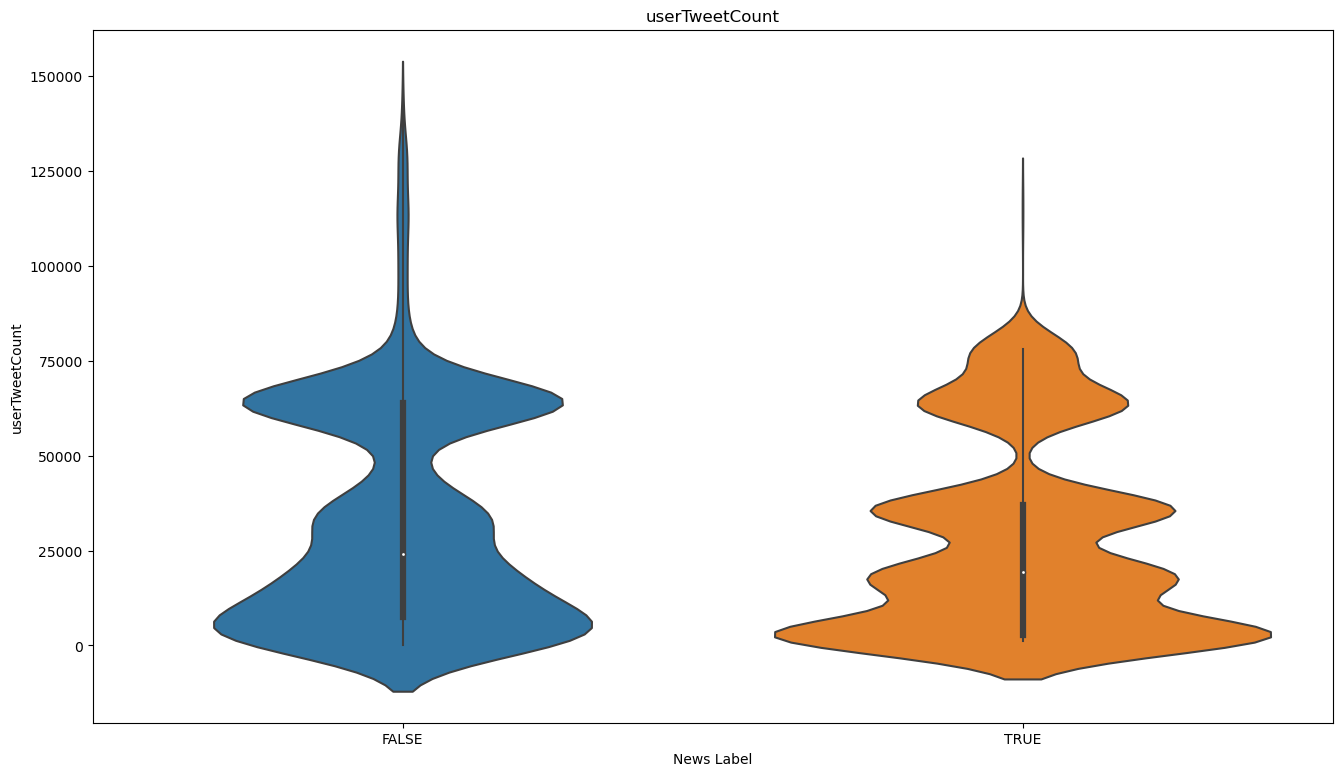

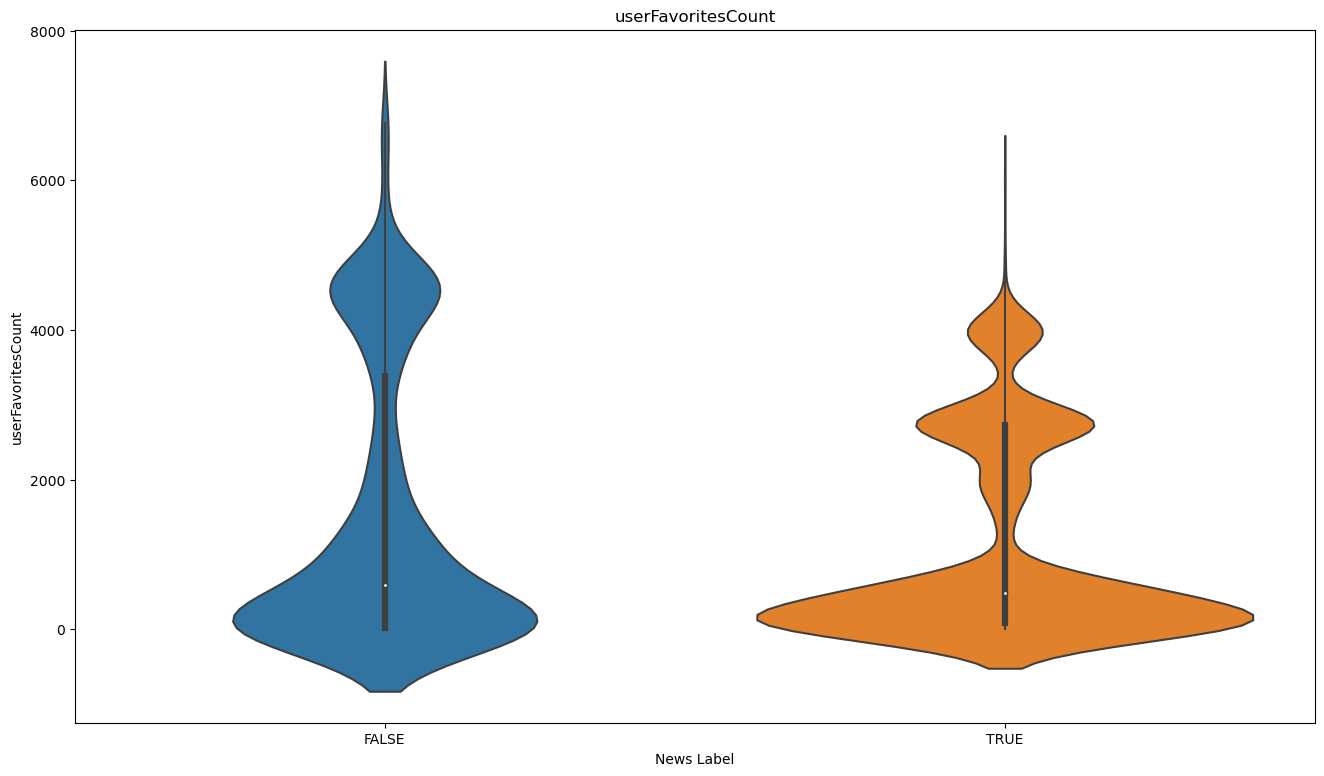

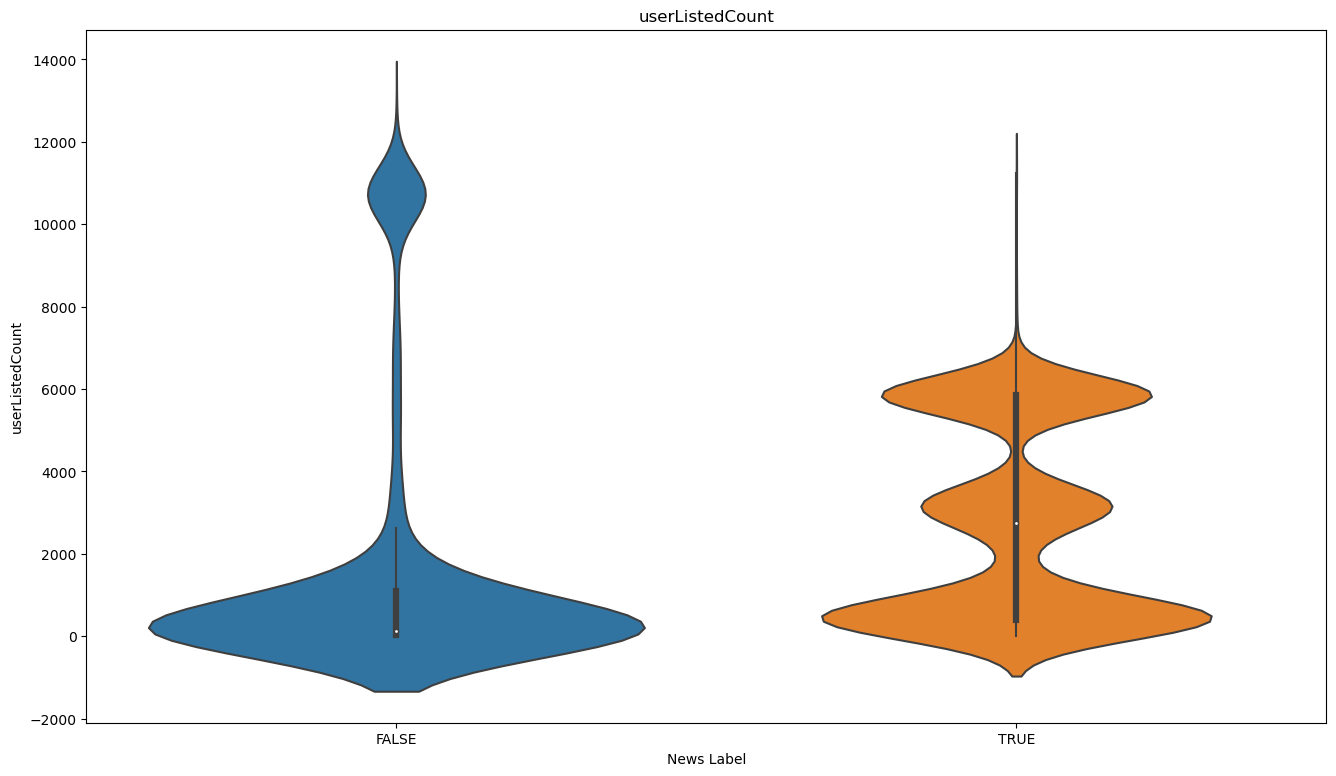

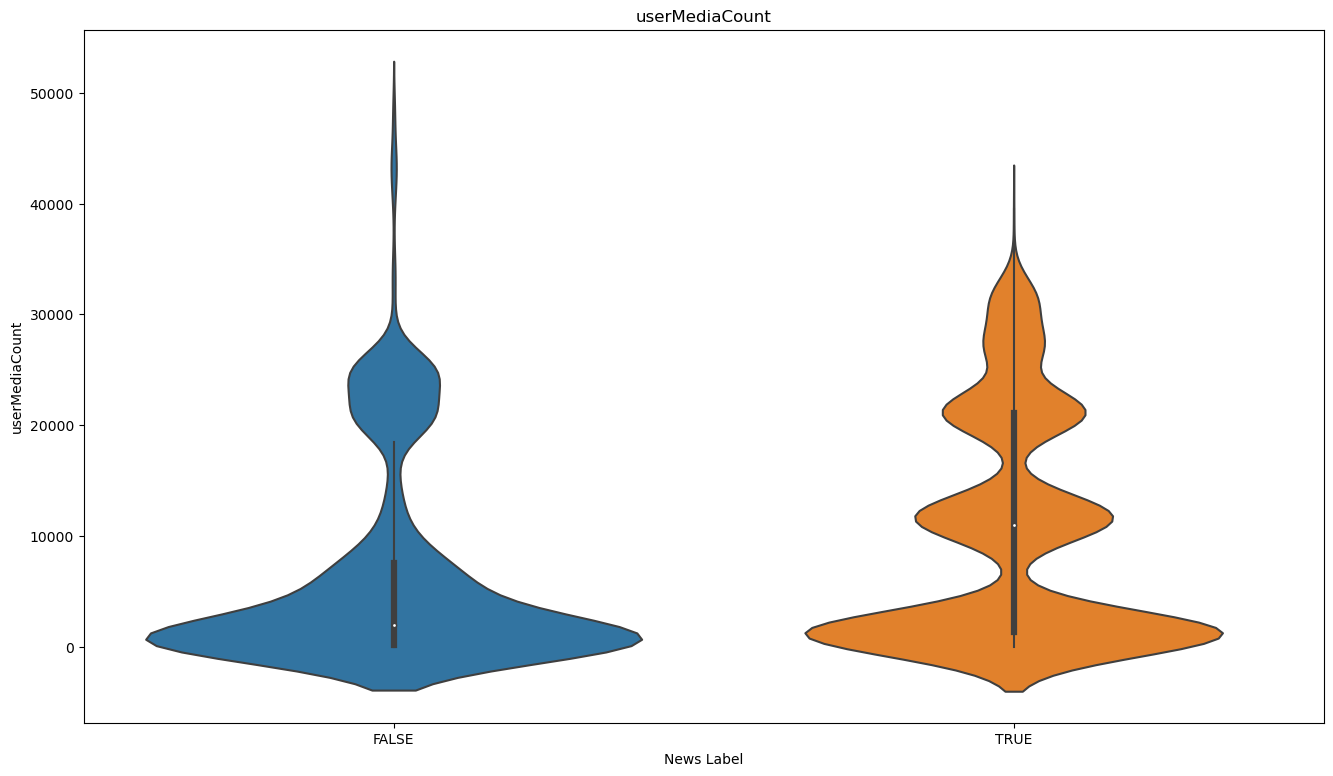

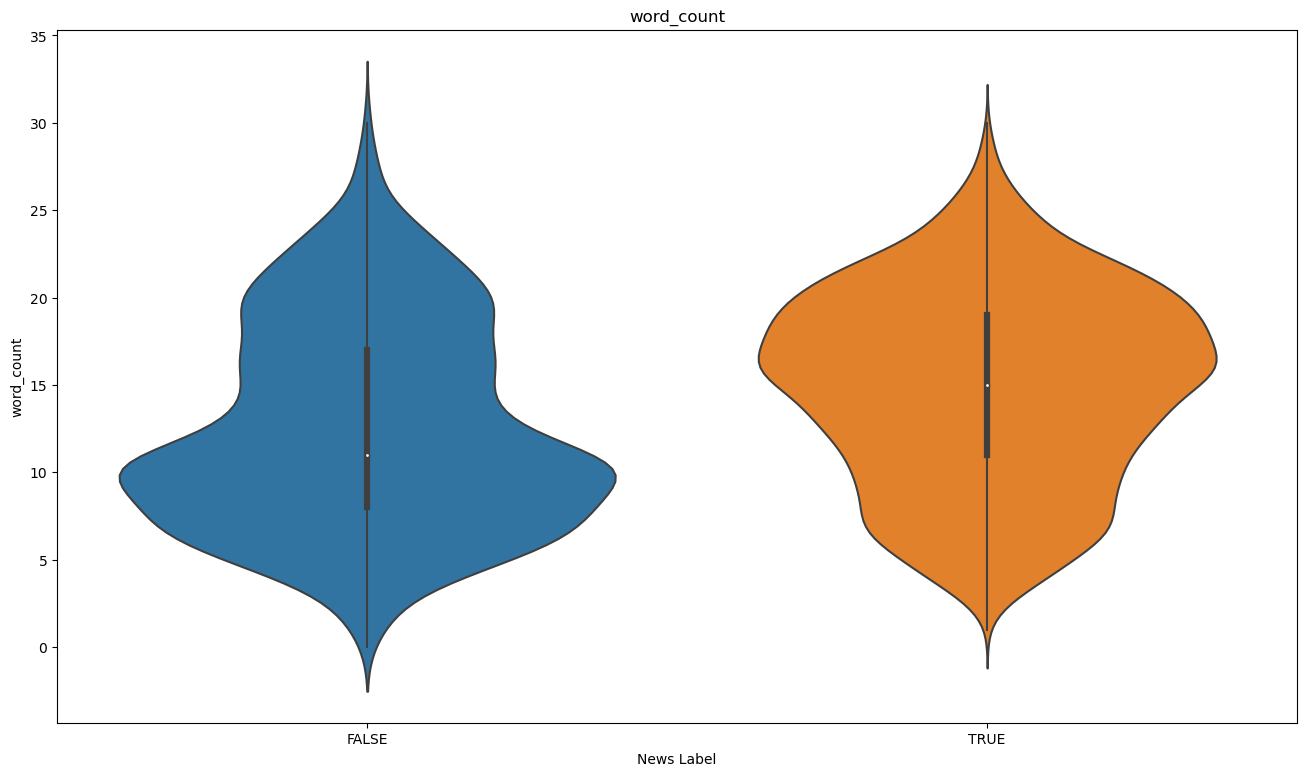

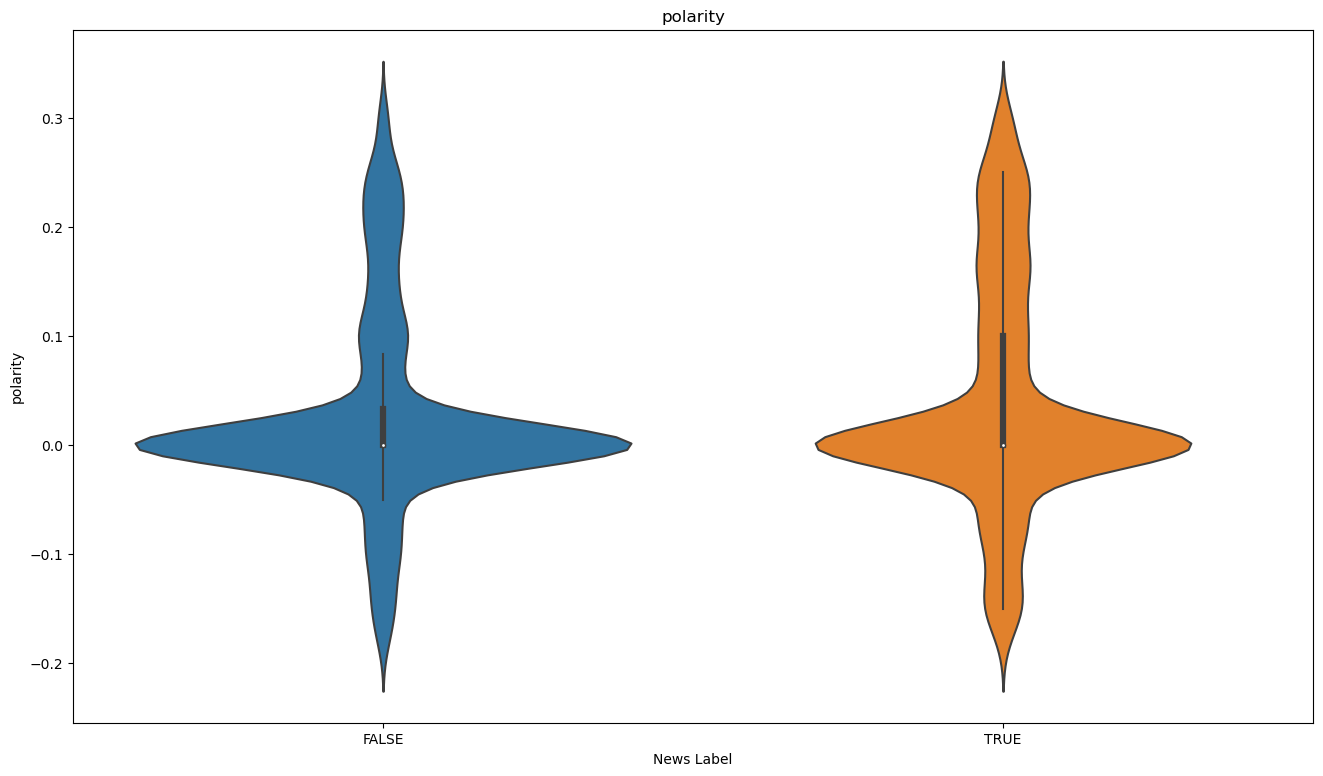

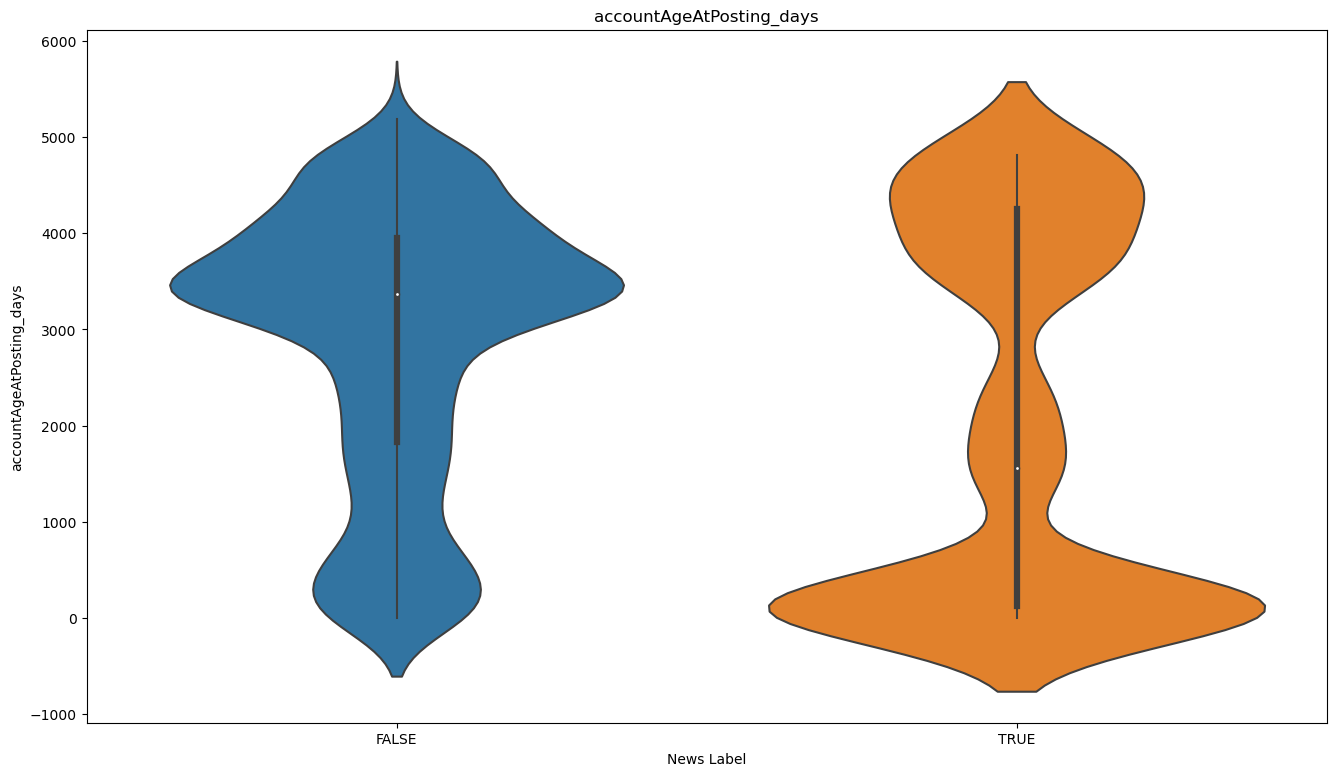

In [33]:
ignore = ['tweetDate', 'tweet', 'tweetID', 'language', 'coordinates', 'hashtags', 'userID', 'userDisplayName', 
          'userDescription', 'userCreated', 'stemmed_tweet', 'parts_of_speech', 'has_links', 'userLocation']

dataset = modified_tweets_df.query('label=="TRUE" or label=="FALSE"')
for col in modified_tweets_df.drop('label', axis=1).columns:
    if col not in ignore:
        dtype = modified_tweets_df[col].dtype
        
        plt.close()
        plt.figure(figsize=(16,9))
        
        if dtype in ('uint8', 'uint16', 'uint32', 'uint64', 'int8', 'int16', 'int32', 'int64', 'int', 'float'):
            data = dataset.loc[:,[col, 'label']]
            Q3 = np.quantile(data[col].to_numpy(), 0.75)
            Q1 = np.quantile(data[col].to_numpy(), 0.25)
            IQR = Q3 - Q1
            max_range = Q3 + 1.5*IQR
            min_range = Q1 - 1.5*IQR
            data = data.query(f'{col} <= {max_range} and {col} >= {min_range}')
            sns.violinplot(data=data, x='label', y=col)
            plt.xlabel('News Label')
            plt.ylabel(col)
            
        elif dtype=='string' or dtype=='bool':
            
            sns.countplot(data=dataset.loc[:,[col, 'label']], x=col, hue='label')
            plt.legend(title='News Label')
            plt.xticks(rotation=45, ha='right')
            plt.xlabel(col)
            plt.ylabel('Count')
        
        plt.title(col)
        plt.show()

## Correlation Analysis

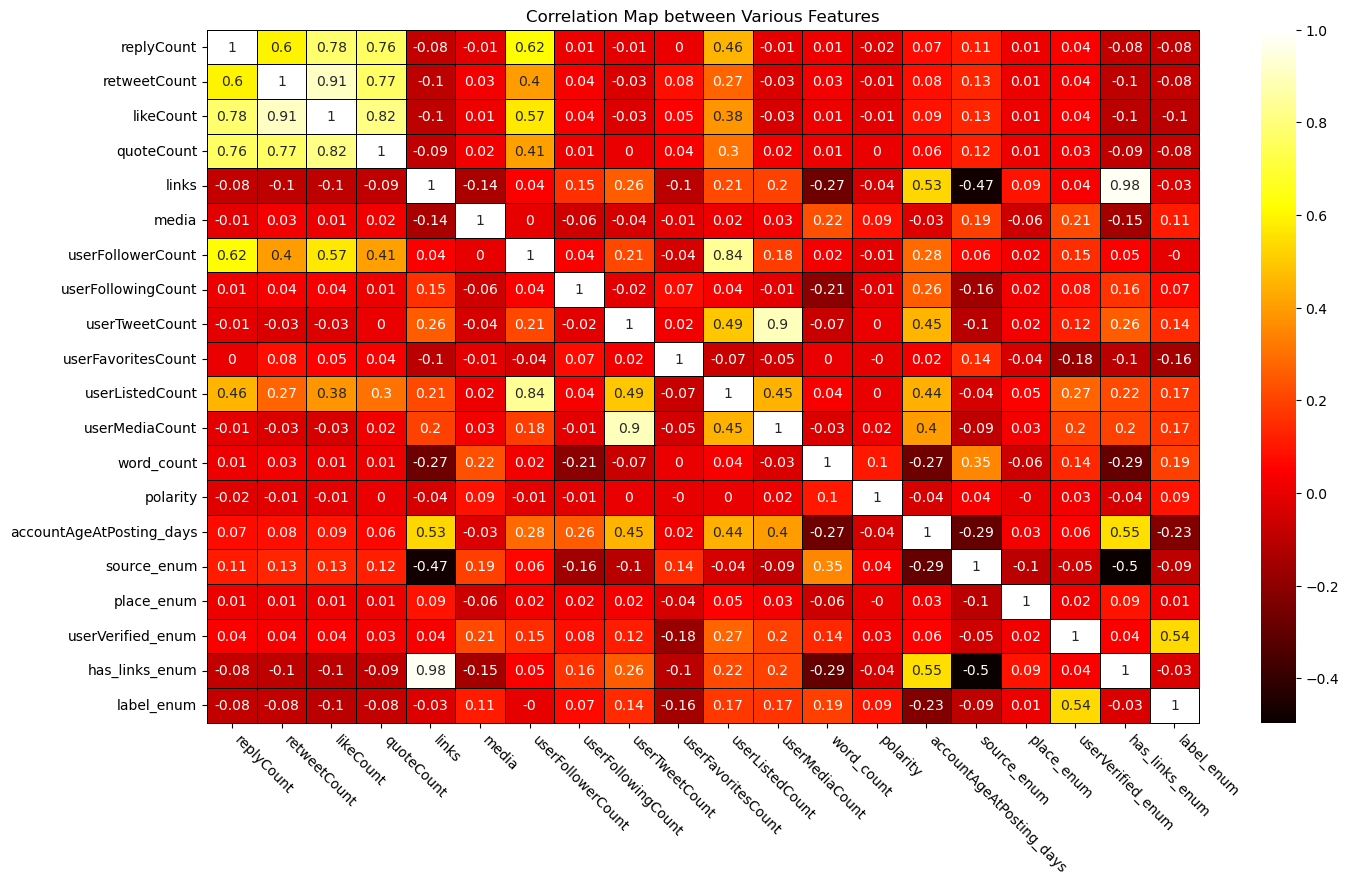

In [38]:
ignore = ['tweetDate', 'tweet', 'tweetID', 'language', 'coordinates', 'hashtags', 'userID', 'userDisplayName', 
          'userDescription', 'userCreated', 'stemmed_tweet','userLocation']

data = modified_tweets_df.query("label=='TRUE' or label=='FALSE'").copy()
data = data.drop(ignore, axis=1)

for col in data.columns:
    dtype = data[col].dtype
    
    if dtype == 'string':
        unique_vals = np.array(data[col].dropna().unique())
        unique_vals.sort()
        data[col+'_enum'] = data[col].astype('object').replace(unique_vals, range(len(unique_vals)))
        data[col+'_enum'] = data[col+'_enum'].fillna(np.nan)
        data[col+'_enum'] = data[col+'_enum'].astype(float)
        data = data.drop(col, axis=1)
        
    if dtype == 'bool':
        data[col+'_enum'] = data[col].astype('object').replace([False, True], [0, 1])
        data[col+'_enum'] = data[col+'_enum'].astype('uint8')
        data = data.drop(col, axis=1)

label_enum = data['label_enum']
data = data.drop('label_enum', axis=1)
data['label_enum'] = label_enum

#data.loc[:,'label_enum'] = 0
#data.loc[data['label']=='TRUE', 'label_enum'] = 1
#data.loc[:,'has_links_enum'] = 0
#data.loc[data['has_links']==True, 'has_links_enum'] = 1
#data = data.loc[:, ['has_links_enum', 'word_count', 'polarity', 'label_enum']]

plt.close()
plt.figure(figsize=(16,9))
correlation = data.corr()
sns.heatmap(data=correlation, annot=np.round(correlation, 2), linecolor='black', linewidth=0.5, clip_on=False, cmap='hot')
plt.title('Correlation Map between Various Features')
plt.xticks(rotation=-45, ha='left')
plt.savefig(image_dir+'feature_correlation_map.png', bbox_inches='tight')
plt.show()

## Parts of Speech

In [39]:
def pos_tagger(sentence):
    blob = TextBlob(sentence)
    pairs = blob.pos_tags
    pos = [pair[1] for pair in pairs]
    return ' '.join(pos)

In [40]:
modified_tweets_df['parts_of_speech'] = modified_tweets_df['tweet'].apply(pos_tagger)

In [41]:
vectorizer = CountVectorizer(token_pattern=r'[^\s]+')
pos_counts = vectorizer.fit_transform(modified_tweets_df['parts_of_speech'].to_numpy()).toarray()
parts_of_speech = vectorizer.get_feature_names_out()

pos_counts = pd.DataFrame(data=pos_counts, columns=parts_of_speech)
pos_counts['label'] = modified_tweets_df['label']
pos_counts = pos_counts.query('label=="FALSE" or label=="TRUE"')

new_col = np.zeros(len(pos_counts))
new_col[np.array(pos_counts['label']=='TRUE', dtype=bool)] = 1
pos_counts['label_enum'] = new_col

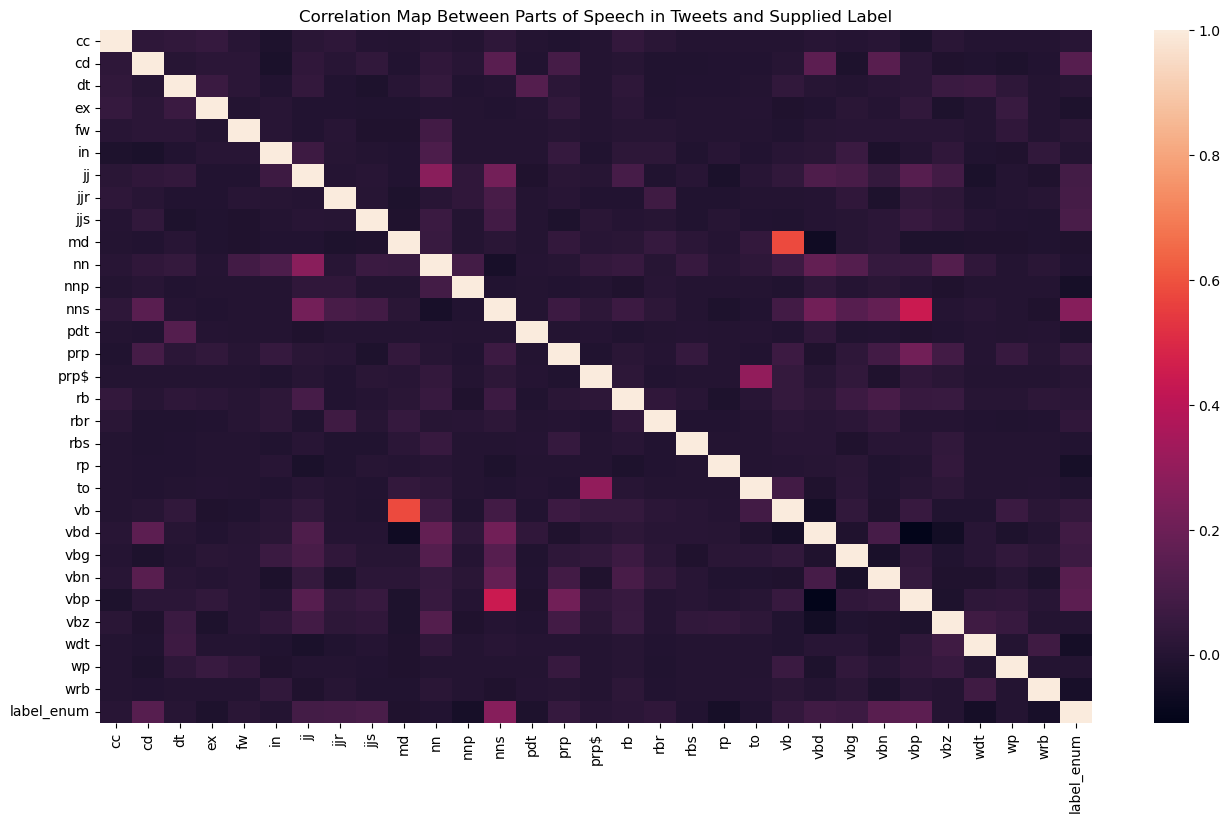

In [42]:
plt.close()
plt.figure(figsize=(16,9))
sns.heatmap(data=pos_counts.drop('label', axis=1).corr())
plt.title('Correlation Map Between Parts of Speech in Tweets and Supplied Label')
plt.savefig(image_dir+'parts_of_speech_correlation_map.png', bbox_inches='tight')
plt.show()

## KMeans Clustering Analysis

In [43]:
vectorizer = TfidfVectorizer(stop_words='english', token_pattern=r'[^\s]+')
all_tfidf = vectorizer.fit_transform(modified_tweets_df['stemmed_tweet'].to_numpy())
tfidf_terms = vectorizer.get_feature_names_out()

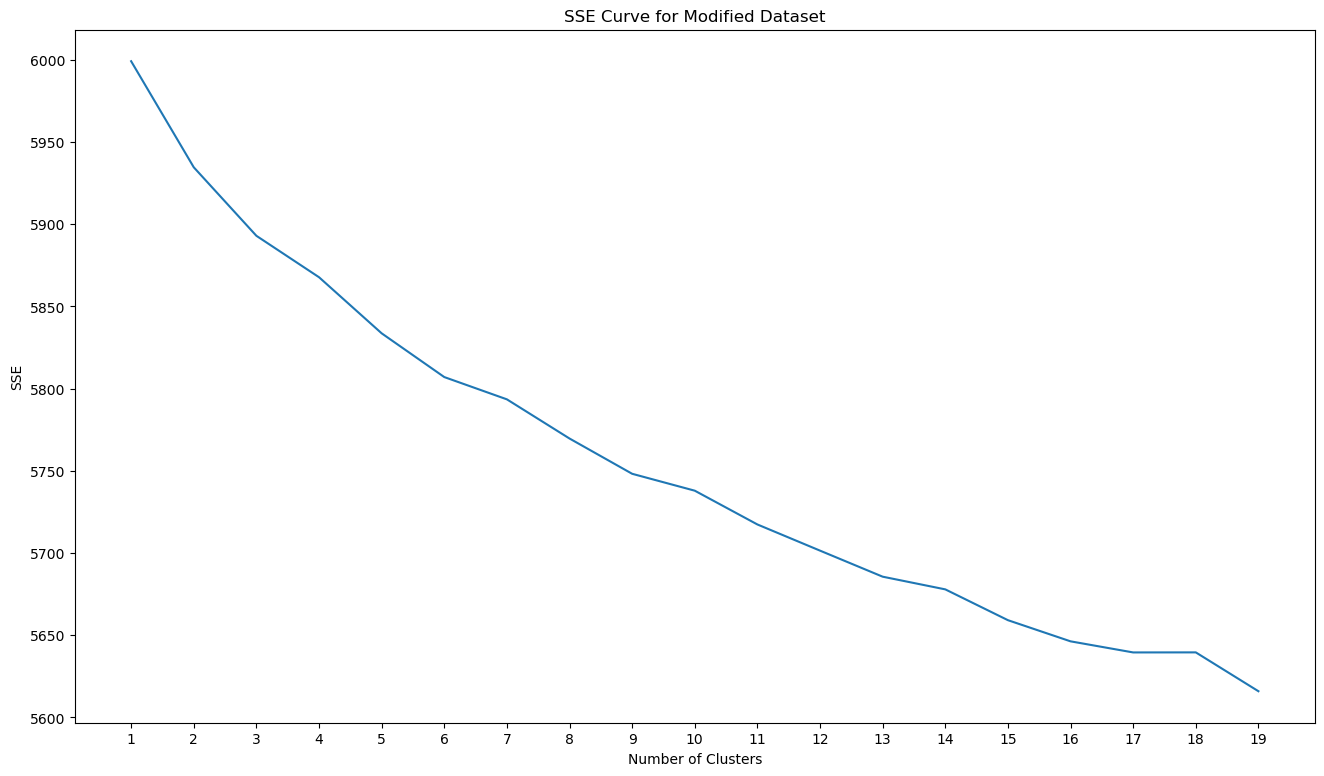

In [51]:
cluster_count = range(1,20)
sse_vals_all = np.zeros(len(cluster_count))

for index, k in enumerate(cluster_count):
    sse_vals_all[index] = KMeans(n_clusters=k, n_init=10).fit(all_tfidf).inertia_
    
plt.close()
plt.figure(figsize=(16,9))
sns.lineplot(x=cluster_count, y=sse_vals_all)
plt.title('SSE Curve for Modified Dataset')
plt.xticks(cluster_count)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.savefig(image_dir+'kmeans_sse_curve.png', bbox_inches='tight')
plt.show()

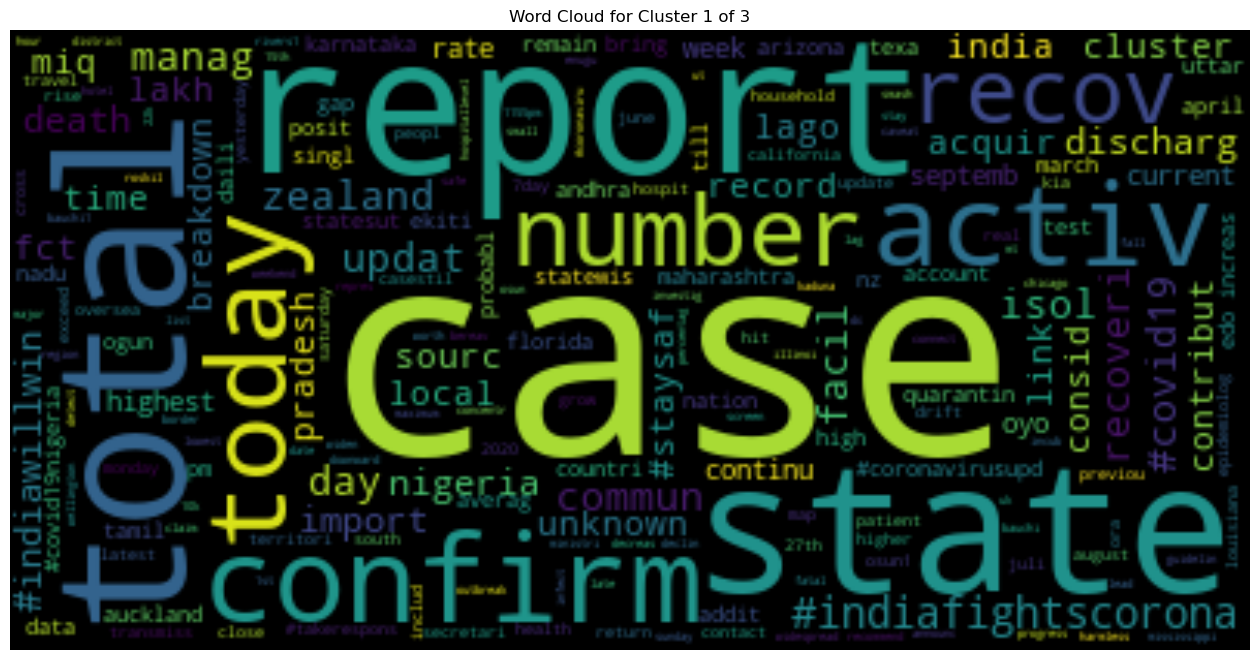

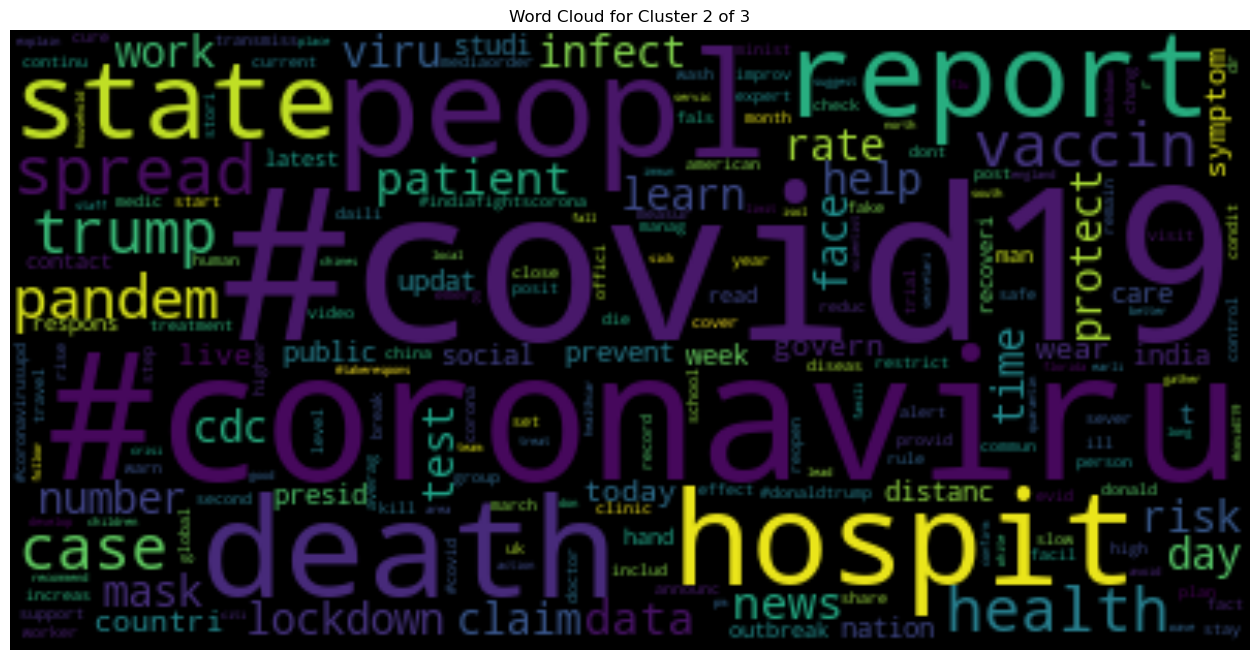

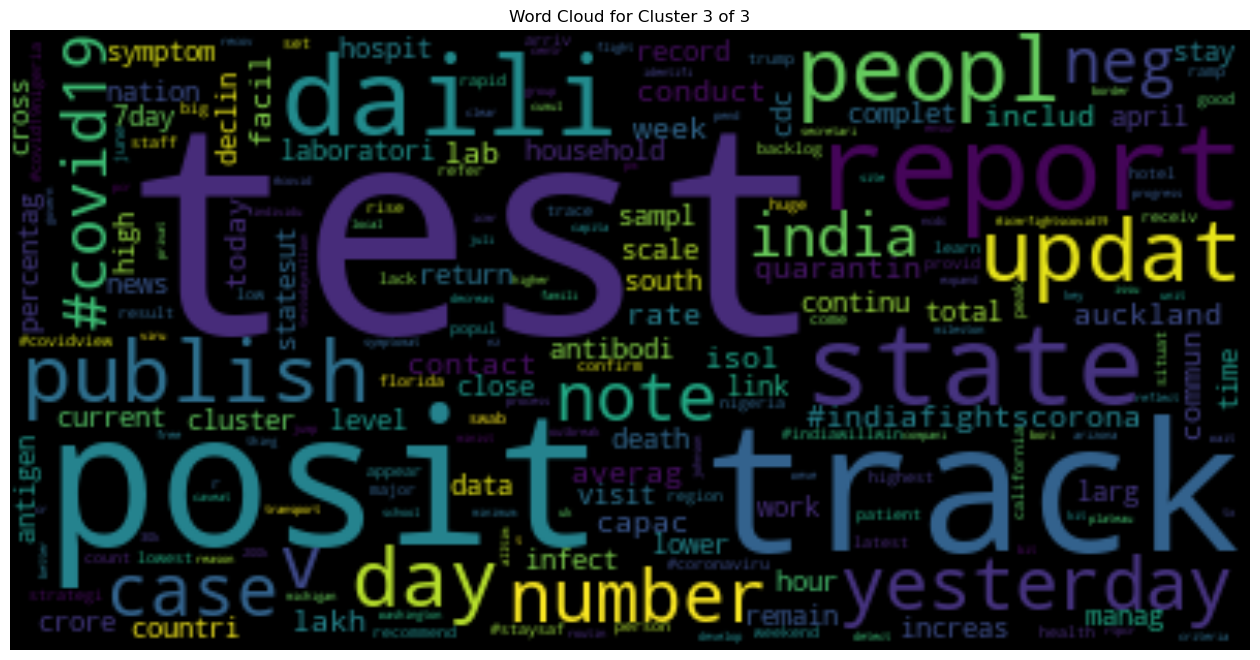

In [45]:
# Visualize 3 clusters using cluster centers as a representation
k=3
model = KMeans(n_clusters=k, n_init=20)
predictions = model.fit_predict(all_tfidf)
centers = model.cluster_centers_

for i, center in enumerate(centers):
    plt.close()
    wordcloud = WordCloud().generate_from_frequencies(dict(zip(tfidf_terms, center)))
    plt.figure(figsize=(16,9))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Cluster {i+1} of {k}')
    plt.axis('off')
    plt.savefig(image_dir+f'cluster_{i+1}_of_{k}_word_cloud.png', bbox_inches='tight')
    plt.show()

## Word Cloud

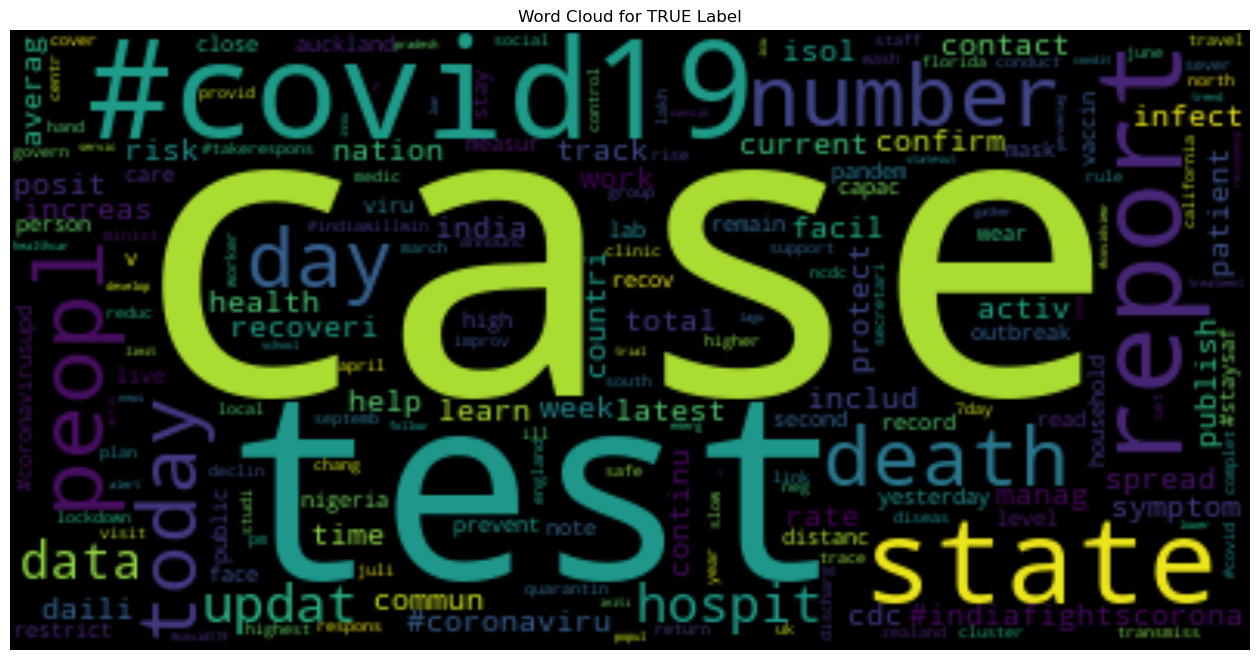

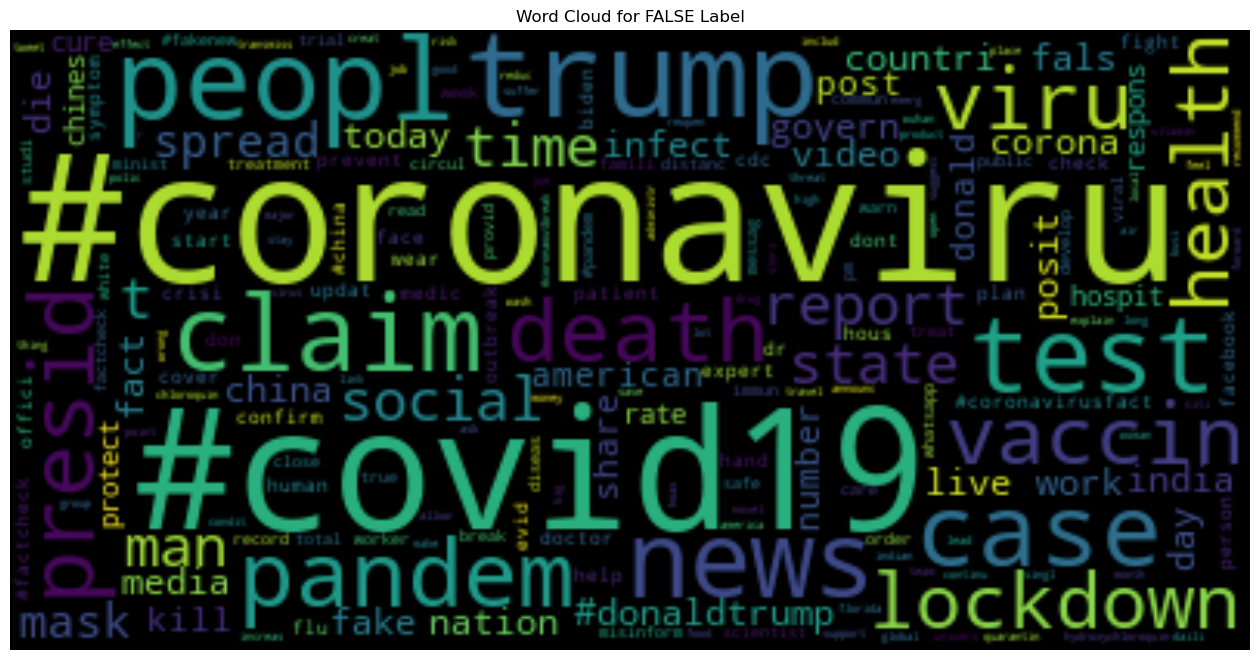

In [46]:
vectorizer = CountVectorizer(stop_words='english', token_pattern=r'[^\s]+')
true_counts = vectorizer.fit_transform(modified_tweets_df.loc[modified_tweets_df['label']=='TRUE', 
                                                              'stemmed_tweet'].to_numpy())
true_terms = vectorizer.get_feature_names_out()
true_term_count = len(true_terms)
false_counts = vectorizer.fit_transform(modified_tweets_df.loc[modified_tweets_df['label']=='FALSE', 
                                                               'stemmed_tweet'].to_numpy())
false_terms = vectorizer.get_feature_names_out()
false_term_count = len(false_terms)

true_frequencies = {k:v for k,v in zip(true_terms, np.array(true_counts.sum(axis=0)).reshape(true_term_count))}
false_frequencies = {k:v for k,v in zip(false_terms, np.array(false_counts.sum(axis=0)).reshape(false_term_count))}

for name, dataset in zip(['TRUE Label', 'FALSE Label'],[true_frequencies, false_frequencies]):
    wordcloud = WordCloud().generate_from_frequencies(dataset)
    plt.close()
    plt.figure(figsize=(16,9))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {name}')
    plt.axis('off')
    plt.savefig(image_dir+f'{"_".join(name.split())}_word_cloud.png', bbox_inches='tight')
    plt.show()

## Top 20 Most Frequent Words in Each Labels

In [47]:
# Top 20 most frequent words in the TRUE labels
true_counts_df = pd.DataFrame(true_frequencies, index=[0])
true_counts_df = true_counts_df.melt(value_vars=true_counts_df.columns, 
                                     var_name='word_in_tweet', 
                                     value_name='word_count')
true_counts_df = true_counts_df.sort_values(by='word_count', ascending=False)
true_counts_df['word_percent'] = round(true_counts_df['word_count']/true_counts_df['word_count'].sum()*100, 2)
true_counts_df = true_counts_df.reset_index(drop=True)
print('Top 20 most frequent words in TRUE labels')
display(true_counts_df.head(20))

Top 20 most frequent words in TRUE labels


word_in_tweet  word_count  word_percent
0                 case        1469          2.93
1                 test        1338          2.66
2             #covid19        1286          2.56
3               report         879          1.75
4                state         857          1.71
5                peopl         512          1.02
6               number         470          0.94
7                death         395          0.79
8                today         383          0.76
9                  day         374          0.74
10              hospit         352          0.70
11               updat         346          0.69
12                data         321          0.64
13  #indiafightscorona         295          0.59
14               total         289          0.58
15              health         278          0.55
16             confirm         274          0.55
17                rate         255          0.51
18               posit         241          0.48
19               daili         239          0.48

In [48]:
# Top 20 most frequent words in the FALSE label
false_counts_df = pd.DataFrame(false_frequencies, index=[0])
false_counts_df = false_counts_df.melt(value_vars=false_counts_df.columns, 
                                     var_name='word_in_tweet', 
                                     value_name='word_count')
false_counts_df = false_counts_df.sort_values(by='word_count', ascending=False)
false_counts_df['word_percent'] = round(false_counts_df['word_count']/false_counts_df['word_count'].sum()*100, 2)
false_counts_df = false_counts_df.reset_index(drop=True)
print('Top 20 most frequent words in FALSE label')
display(false_counts_df.head(20))

Top 20 most frequent words in FALSE label


word_in_tweet  word_count  word_percent
0    #coronaviru         447          1.55
1       #covid19         398          1.38
2          trump         263          0.91
3          peopl         237          0.82
4           news         201          0.70
5          claim         198          0.69
6           test         195          0.68
7           case         179          0.62
8         pandem         148          0.51
9         presid         138          0.48
10         death         133          0.46
11        vaccin         131          0.45
12          viru         130          0.45
13      lockdown         106          0.37
14        health         105          0.36
15        report         104          0.36
16          time         101          0.35
17             t          98          0.34
18        social          96          0.33
19         state          96          0.33

### Top 20 Most Extreme Terms for True and False Labels

In [49]:
# Top 20 most extreme terms for TRUE and FALSE labels. Values close to 0 are almost exclusively
# used in FALSE label and the larger the value, the more exclusive it is to TRUE labels
count_comparison = pd.merge(left=true_counts_df, right=false_counts_df, 
                            on='word_in_tweet', suffixes=['_true', '_false'],
                            how='outer')
count_comparison = count_comparison.drop(['word_percent_true', 'word_percent_false'], axis=1)

# add 1 to each term for Laplace smoothing
count_comparison['word_count_true'] = count_comparison['word_count_true']+1
count_comparison['word_count_false'] = count_comparison['word_count_false']+1
count_comparison = count_comparison.fillna(1.0)

count_comparison['true_frequency'] = count_comparison['word_count_true']/count_comparison['word_count_true'].sum()
count_comparison['false_frequency'] = count_comparison['word_count_false']/count_comparison['word_count_false'].sum()

count_comparison['frequency_ratio'] = count_comparison['true_frequency']/count_comparison['false_frequency']

count_comparison = count_comparison.sort_values(by='frequency_ratio', ascending=False)
print('Top 20 terms that appear primarily only in TRUE labels')
display(count_comparison[['word_in_tweet', 'frequency_ratio']].head(20))

count_comparison = count_comparison.sort_values(by='frequency_ratio', ascending=True)
print('Top 20 terms that appear primarily only in FALSE labels')
display(count_comparison[['word_in_tweet', 'frequency_ratio']].head(20))

Top 20 terms that appear primarily only in TRUE labels


word_in_tweet  frequency_ratio
62        auckland        74.732249
89   #indiawillwin        55.570134
125           7day        44.072865
151        england        36.408019
170       statesut        31.936858
184     #covidview        30.659384
179      percentag        30.659384
86          improv        29.701278
231     #kayburley        25.549487
238         steadi        24.910750
260            miq        22.994538
262          cumul        22.355801
263            fct        22.355801
277            lag        21.078327
290         metric        20.439589
300         acquir        19.800852
302        arizona        19.800852
138         declin        19.481484
310         andhra        19.162115
312            pub        19.162115

Top 20 terms that appear primarily only in FALSE labels


word_in_tweet  frequency_ratio
4713      #donaldtrump         0.007019
4714  #coronavirusfact         0.011406
4715        #factcheck         0.015579
4716         misinform         0.016378
4717             biden         0.016378
4718          #fakenew         0.017743
3731              fake         0.018250
4719         factcheck         0.019961
4720   #coronaoutbreak         0.027771
2254              kill         0.028600
4721             truth         0.029034
4722           #health         0.031937
4723               lie         0.031937
3266            #china         0.032756
4726             photo         0.033618
4724             rumor         0.033618
4725             blame         0.033618
4727        conspiraci         0.035485
1493            corona         0.035485
1700              fals         0.035884